# TRABAJO FIN DE MASTER - Imputación valores calidad aire - Regresión
# **Author**: Cristóbal León-Salas
# **Date**: 2025-08-11

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  matplotlib --> Para hacer visualizaciones gráficas básicas.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más lista
-  display --> Para sacar tablas con formato.
-  KNeighborsRegressor --> Para obtener pronóstico con K-vecinos
-  ExponentialSmoothing --> Para hacer predicciones con suavizados exponenciales (Holt-Winters)
-  folium --> Para representación georreferenciada
-  unicodedata --> Permite manejar caracteres Unicode, como letras con acentos, eñes, tildes, etc.
-  re --> Es la librería estándar de Python para trabajar con expresiones regulares. Se usa para encontrar o reemplazar patrones de texto.
-  StandardScaler --> Para el normalizado y escalado de las variables
-  PCA --> Para llevar a cabo la técnica de componentes principales
-  mean_absolute_error, mean_squared_error --> Para hallar las métricas de los modelos
-  LGBMRegressor --> Para aplicar modelo LGBM
-  XGBRegressor--> Para aplicar modelos XGBOOST
-  Prophet --> Para aplciar modelos Prophet


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from IPython.display import display
import folium
from ydata_profiling import ProfileReport
from skimpy import skim
import unicodedata
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from prophet import Prophet

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# FUNCIONES

## FUNCIÓN Fechas_faltantes

Extraigo las fechas que faltan de un subconjunto del dataframe

In [2]:
def fechas_faltantes(df, fecha_col="DIA/MES/ANO", start=None, end=None, normalize=True):
 
    # Convertir columna a datetime
    fechas = pd.to_datetime(df[fecha_col], errors="coerce")
    if normalize:
        fechas = fechas.dt.normalize()

    # Determinar rango
    if start is None:
        start = fechas.min()
    else:
        start = pd.to_datetime(start)
    if end is None:
        end = fechas.max()
    else:
        end = pd.to_datetime(end)

    if pd.isna(start) or pd.isna(end):
        # Si no hay fechas válidas, no podemos construir rango
        return pd.DatetimeIndex([])

    # Rango completo diario
    rango = pd.date_range(start=start, end=end, freq="D")

    # Fechas existentes únicas
    existentes = pd.DatetimeIndex(fechas.dropna().unique())

    # Diferencia (las que faltan)
    faltantes = rango.difference(existentes)

    return faltantes

## FUNCIÓN all_zonas_por dia

Dado un dataframe, me va a devolver, los días que están incompletos, llamando incompletos a aquellos dias, donde no existen mediciones de una magnitud en todas las zonas gegráficas en las que se ha dividido el dataframey un dataframe detallando estos días incompletos

In [3]:
def all_zonas_por_dia(
    df,
    fecha_col="DIA/MES/ANO",
    zona_col="ZONA_ESTACION",
    n_zonas_esperadas=None,
    zonas_universo=None
):
    """
    Comprueba por día cuántas zonas aparecen y devuelve días incompletos y detalle de zonas faltantes.
    Si 'zonas_universo' se pasa, los faltantes se calculan contra ese universo fijo.
    """

    # 1) Normalizar fechas (a diario)
    fechas = pd.to_datetime(df[fecha_col], errors="coerce").dt.normalize()
    df = df.assign(__FECHA__=fechas)

    if df.empty or df["__FECHA__"].notna().sum() == 0:
        dias_incompletos = pd.Series(dtype="int64")
        faltantes_por_dia = pd.DataFrame(
            columns=["fecha", "zonas_presentes", "zonas_faltantes", "n_presentes", "n_faltantes"]
        )
        return dias_incompletos, faltantes_por_dia

    # 2) Universo de zonas y nº esperado
    if zonas_universo is not None:
        zonas_totales = list(pd.Index(zonas_universo).dropna().unique())
        n_zonas = len(zonas_totales)  # coherente con el universo fijo
    else:
        zonas_totales = sorted(df[zona_col].dropna().unique().tolist())
        n_zonas = n_zonas_esperadas if n_zonas_esperadas is not None else len(zonas_totales)

    # 3) Conteo de zonas presentes por día
    conteo = (
        df.groupby("__FECHA__")[zona_col]
          .nunique()
          .sort_index()
    )

    # 4) Días incompletos
    dias_incompletos = conteo[conteo < n_zonas]

    # 5) Detalle de faltantes
    registros = []
    zonas_totales_set = set(zonas_totales)
    for fecha, n_presentes in dias_incompletos.items():
        presentes = set(
            df.loc[df["__FECHA__"] == fecha, zona_col]
              .dropna()
              .unique()
              .tolist()
        )
        faltan = sorted(zonas_totales_set - presentes)
        registros.append({
            "fecha": fecha,
            "zonas_presentes": sorted(presentes),
            "zonas_faltantes": faltan,
            "n_presentes": int(n_presentes),
            "n_faltantes": int(n_zonas - n_presentes)
        })

    faltantes_por_dia = pd.DataFrame(
        registros,
        columns=["fecha", "zonas_presentes", "zonas_faltantes", "n_presentes", "n_faltantes"]
    )
    if not faltantes_por_dia.empty:
        faltantes_por_dia = faltantes_por_dia.sort_values("fecha")

    return dias_incompletos, faltantes_por_dia

## FUNCIÓN resumen_cobertura_por_magnitud

Función que me itera cada uno de los niveles de la función magnitud y me pasa detalles de los días faltantes (días donde no todas las zonas miden estas magnitudes)

In [4]:
def resumen_cobertura_por_magnitud(df, magnitud_col="MAGNITUD",
                                   fecha_col="DIA/MES/ANO", zona_col="ZONA_ESTACION",
                                   zonas_universo=None):
    filas, detalles = [], {}
    for nivel, subset in df.groupby(magnitud_col, dropna=True, observed=True):
        subset = subset.copy()
        subset[fecha_col] = pd.to_datetime(subset[fecha_col], errors="coerce").dt.normalize()
        fmin, fmax = subset[fecha_col].min(), subset[fecha_col].max()
        dias_total = subset[fecha_col].nunique()

        dias_incomp, falt = all_zonas_por_dia(
            subset, fecha_col=fecha_col, zona_col=zona_col, zonas_universo=zonas_universo
        )
        dias_incomp_n = int(len(dias_incomp))
        cobertura_pct = 100 * (1 - dias_incomp_n / dias_total) if dias_total > 0 else 0.0

        filas.append({
            "MAGNITUD": nivel,
            "Fecha mínima": fmin.date() if pd.notna(fmin) else None,
            "Fecha máxima": fmax.date() if pd.notna(fmax) else None,
            "Días Totales": int(dias_total),
            f"Días incompletos (<{len(zonas_universo) if zonas_universo else 'N'} zonas)": dias_incomp_n,
            "Cobertura días completos (%)": round(cobertura_pct, 2),
        })
        detalles[nivel] = falt

    resumen = (pd.DataFrame(filas)
               .sort_values(["Cobertura días completos (%)"],
                            ascending=[True])
               .reset_index(drop=True))
    return resumen, detalles

## FUNCIÓN cast_magn

Esta función convierte cada clave de gaps_map a df_magn_type. Se evita así que falle el cruce por desajuste de tipos (por ejemplo, MAGNITUD como "1" string en el DF y 1 entero en gaps_map no coinciden en un merge).

In [5]:
def cast_magn(val):
    try:
        return df_magn_type(val)
    except Exception:
        return val

## FUNCIÓN add_missing_daily_instances_known_gaps

Añade filas (fecha × magnitud × zona) según las zonas faltantes y para todas las fechas contenidas en el dataframe original:
- En MEDICION_ugm3 se fijan valores ausentes en las filas nuevas.
- meteo_cols se rellenan con la media del mismo día.

In [6]:
def add_missing_daily_instances_known_gaps(
    df,
    date_col="DIA/MES/ANO",
    zone_col="ZONA_ESTACION",
    magn_col="MAGNITUD",
    value_col="MEDICION_ugm3",
    meteo_cols=None,             # si None: se detectan numéricas (float) ≠ value_col
    gaps_map=None,               # dict: {magnitud: [zonas_faltantes,...]}
    start_date=None,             # rango explícito
    end_date=None,               # rango explícito
    ffill_meteo=True             # propagar medias de meteo hacia adelante
):
    # -------- 0) Copia + validaciones
    df = df.copy()
    for col in [date_col, zone_col, magn_col]:
        if col not in df.columns:
            raise ValueError(f"Falta la columna requerida '{col}' en el dataframe.")

    # Fechas a datetime normalizadas
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.normalize()
    if df[date_col].isna().all():
        raise ValueError(f"No se pudieron parsear fechas en '{date_col}'.")

    # Rango temporal (obligatorio en tu caso)
    if start_date is None or end_date is None:
        raise ValueError("Se debe proporcionar 'start_date' y 'end_date' explícitos.")

    start_date = pd.to_datetime(start_date).normalize()
    end_date   = pd.to_datetime(end_date).normalize()

    # Ordenar si vinieran invertidos
    start_date, end_date = sorted([start_date, end_date])

    # Serie de días
    days = pd.date_range(start=start_date, end=end_date, freq="D")
    days_df = pd.DataFrame({date_col: days})

    # Subconjunto del rango (para medias)
    in_range = df[df[date_col].between(start_date, end_date)].copy()

    # -------- 1) Columnas meteo
    if meteo_cols is None:
        # Solo floats (cubre float32/float64) y excluye value_col
        meteo_cols = (
            df.select_dtypes(include=[np.floating])
              .columns.drop(value_col, errors="ignore")
              .tolist()
        )

    # -------- 2) gaps_map → pares (magnitud, zona)
    if not gaps_map or not isinstance(gaps_map, dict):
        raise ValueError("Debes pasar 'gaps_map' con el formato {magnitud: [zonas_faltantes,...]}")

    # Detectar tipo dominante de la columna magnitud para castear las claves del gaps_map
    if pd.api.types.is_integer_dtype(df[magn_col]):
        magn_cast_type = int
    elif pd.api.types.is_float_dtype(df[magn_col]):
        magn_cast_type = float
    else:
        magn_cast_type = str

    pairs = []
    for mag, zonas in gaps_map.items():
        mag_cast = cast_magn(mag)
        for z in zonas:
            pairs.append({magn_col: mag_cast, zone_col: z})
    pairs = pd.DataFrame(pairs)

    if pairs.empty:
        df_out = df.sort_values([date_col, zone_col, magn_col]).reset_index(drop=True)
        print("No hay pares (magnitud-zona) en gaps_map.")
        return df_out

    # -------- 3) Claves deseadas y presentes
    desired_keys = days_df.merge(pairs, how="cross")  # (fecha × magnitud × zona)

    keys_present = (
        df[[date_col, zone_col, magn_col]]
        .dropna()
        .drop_duplicates()
    )

    # Anti-join: quedarnos con lo que falta
    missing_keys = (
        desired_keys.merge(
            keys_present,
            on=[date_col, zone_col, magn_col],
            how="left",
            indicator=True
        )
        .query("_merge == 'left_only'")
        .drop(columns="_merge")
    )

    if missing_keys.empty:
        df_out = df.sort_values([date_col, zone_col, magn_col]).reset_index(drop=True)
        print("No había combinaciones faltantes (según gaps_map) dentro del rango.")
        return df_out

    # -------- 4) Medias diarias de meteo (global por día)
    if meteo_cols:
        day_means = (
            in_range.groupby(date_col, as_index=False)[meteo_cols]
                    .mean()
        )
        # asegurar todas las fechas del rango para poder ffill si procede
        day_means = days_df.merge(day_means, on=date_col, how="left")
        if ffill_meteo:
            day_means[meteo_cols] = day_means[meteo_cols].ffill()
    else:
        day_means = days_df.copy()

    # -------- 5) Construir filas nuevas
    missing_rows = missing_keys.merge(day_means, on=date_col, how="left")

    # Asegurar todas las columnas originales
    for col in df.columns:
        if col not in missing_rows.columns:
            missing_rows[col] = np.nan

    # Forzar el valor del contaminante a NaN en filas nuevas
    if value_col in missing_rows.columns:
        missing_rows[value_col] = np.nan

    # Orden de columnas = orden original
    missing_rows = missing_rows[df.columns]

    # -------- 6) Unir, ordenar y devolver
    df_out = pd.concat([df, missing_rows], ignore_index=True)
    df_out = df_out.sort_values([date_col, zone_col, magn_col]).reset_index(drop=True)

    print(f"Rango cubierto: {start_date.date()} → {end_date.date()}")
    print(f"Filas añadidas (según gaps_map): {len(missing_rows):,}")
    if meteo_cols:
        print(f"Meteo cols: {meteo_cols} | forward-fill: {ffill_meteo}")

    return df_out

## FUNCIÓN sample_full_rows_by_mags_days

Toma instancias de días al azar para corroborar que la inclusión de las nuevas instancias ausentes se han incluido correctamente.

Filtra el DF por 3 magnitudes (por defecto elegidas al azar de gaps_map que existan en el DF) y devuelve, para cada una, 5 días aleatorios (o menos si no hay tantos).

Devuelve TODAS las filas (todas las columnas/zonas) del DF para:
- magnitudes indicadas (o hasta n_mags elegidas del gaps_map presentes en el DF)
- n_days fechas aleatorias por cada magnitud (si hay menos, devuelve las disponibles).
- Asume MAGNITUD categórica: se compara como string.


In [7]:
def sample_full_rows_by_mags_days(
    df,
    gaps_map,                         # dict con magnitudes (se usa solo para validar/seleccionar)
    selected_mags=None,               # p.ej. ["1","20","14"] (o [1,20,14], se convierte a str)
    date_col="DIA/MES/ANO",
    magn_col="MAGNITUD",
    n_mags=3,                         # si no pasas selected_mags: elige hasta n_mags que existan en el DF
    n_days=5,                         # nº de días aleatorios por magnitud (si hay menos, toma los disponibles)
    seed=42
):
 
    # --- Normaliza fechas a datetime diario (importante si vienen con hora)
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.normalize()

    # --- Clave auxiliar como string para MAGNITUD (robusto a "1"/1/1.0)
    df["_MAGN_STR_"] = df[magn_col].astype(str).str.strip() # Nos aseguramos que se trata como string para evitar confusiones

    # --- Magnitudes presentes en el DF (como string)
    present = set(df["_MAGN_STR_"].dropna().unique()) # Se observan que magnitudes presentes existen en el dataframe (todas las magnitudes)

    # --- Semilla para reproducibilidad
    rng = np.random.default_rng(seed)

    # --- Determinar las magnitudes a usar
    if selected_mags is None:
        # Si no se pasa lista, parte de gaps_map y filtra por las que realmente están en el DF
        mags_all = [str(m) for m in gaps_map.keys()] # keys() es un método de los diccionarios de Python que devuelve una vista (iterable) de todas las claves del diccionario.
        candidates = [m for m in mags_all if m in present]
        if not candidates:
            raise ValueError("Ninguna magnitud de gaps_map está presente en el dataframe.")
        # Elige aleatoriamente hasta n_mags (o todas si hay <= n_mags)
        chosen = list(rng.choice(candidates, size=min(n_mags, len(candidates)), replace=False))
    else:
        # Si te pasan lista explícita, normalízala a string y verifica que existan en el DF
        chosen = [str(m).strip() for m in selected_mags if str(m).strip() in present]
        if not chosen:
            muestra = sorted(list(present))[:25]  # pequeño muestreo para facilitar el debug
            raise ValueError(f"Las magnitudes indicadas no están en el DF. Presentes (muestra): {muestra}")

    # --- Para cada magnitud, muestrea n_days fechas y extrae TODAS las filas del DF en esas fechas
    parts = []
    for m in chosen:
        # Días únicos donde hay datos para esa magnitud
        dias = (df.loc[df["_MAGN_STR_"] == m, [date_col]]
                  .dropna()
                  .drop_duplicates()
                  .sort_values(by=date_col)[date_col]
                  .to_numpy())

        # Si no hay días, pasa a la siguiente magnitud
        if len(dias) == 0:
            continue

        # Toma hasta n_days aleatorios (sin reemplazo)
        k = min(n_days, len(dias))
        idx = rng.choice(len(dias), size=k, replace=False)
        sampled_days = pd.to_datetime(dias[idx]).normalize()

        # Subconjunto completo del DF para (magnitud=m) y (fecha ∈ sampled_days)
        part = df.loc[(df["_MAGN_STR_"] == m) & (df[date_col].isin(sampled_days))].copy()
        parts.append(part)

    # --- Unir resultados
    out = pd.concat(parts, ignore_index=True) if parts else df.iloc[0:0].copy()

    # --- Limpiar columna auxiliar y ordenar
    out = out.drop(columns=["_MAGN_STR_"]).sort_values([magn_col, date_col]).reset_index(drop=True)

    return out, chosen

## FUNCIÓN count_rows_by_mag_day

Ayudante para validar cuántas filas (p. ej., zonas/estaciones) se devuelven por cada (MAGNITUD, día) en el subconjunto resultante.

In [8]:
def count_rows_by_mag_day(df, date_col="DIA/MES/ANO", magn_col="MAGNITUD"):
    return (df.groupby([magn_col, date_col], as_index=False)
              .size()
              .rename(columns={"size": "n_filas"}))

## FUNCIÓN normalize_text

Función que me sirve para normalizar el texto de dos varaibles categóricas

In [9]:
def normalize_text(s: pd.Series) -> pd.Series:
    # a string, quitar espacios, colapsar espacios internos, quitar tildes y poner en mayúsculas
    s = s.astype(str).str.strip()
    s = s.str.replace(r"\s+", " ", regex=True)  # "Norte  Centro" -> "Norte Centro"
    s = s.apply(lambda x: unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii"))
    s = s.str.upper()
    return s

## FUNCIÓN plot_corr_heatmap

Función que me va a permitir extraer matriz de correlaciones de variables numéricas

In [10]:
def plot_corr_heatmap(corr, title="Matriz de correlaciones"):
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(corr, aspect='auto')
    # imshow espera un array 2D (n×n); cada celda se colorea según el valor.
    # aspect='auto' deja que Matplotlib ajuste la relación de aspecto para que quepa todo.    
    ax.set_xticks(range(corr.shape[1])) # Columnas de la matriz de correlación
    ax.set_yticks(range(corr.shape[0])) # Filas de la matriz de correlación
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.index)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

## FUNCIÓN graf_sedimentacion

Fución que me va a permitir representar gráficos de sedimentación

In [11]:
def graf_sedimentacion (explained_ratio, title="GRÁFICOS SEDIMENTACIÓN (Varianza explicada)"):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(range(1, len(explained_ratio)+1), explained_ratio, marker='o')
    ax.set_xlabel("Componente principal")
    ax.set_ylabel("Proporción de varianza explicada")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## FUNCIÓN plot_biplot

Fución que me va a permitir identificar las zonas más semejantes

In [12]:
def plot_biplot (X_pca, labels=None, title="PCA (PC1 vs PC2)", point_size=40):
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=point_size, alpha=0.7)

    if labels is not None:
        for i, txt in enumerate(labels):
            ax.text(X_pca[i, 0], X_pca[i, 1], str(txt), fontsize=8)

    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## FUNCIÓN add_calendar_features

El objetivo de esta función es agregar variables derivadas del calendario que pueden ser útiles para modelos de machine learning, análisis estacional o series temporales (dias de la semana, meses, dias del año, estacionalidad continua,...)

In [13]:
def add_calendar_features(df, date_col="DIA/MES/ANO"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["dow"] = df[date_col].dt.weekday                 # 0..6
    df["month"] = df[date_col].dt.month                 # 1..12
    df["dayofyear"] = df[date_col].dt.dayofyear         # 1..365/366
    # Estacionalidad continua
    df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)
    df["m_sin"]    = np.sin(2*np.pi*df["month"]/12)
    df["m_cos"]    = np.cos(2*np.pi*df["month"]/12)
    df["doy_sin"]  = np.sin(2*np.pi*df["dayofyear"]/365.25)
    df["doy_cos"]  = np.cos(2*np.pi*df["dayofyear"]/365.25)
    return df

## FUNCIÓN prepare_pair_df

El objetivo de esta función es filtrar por una combinación específica de magnitud y estación, asegurar continuidad temporal diaria, añadir variables exógenas y enriquecer con características de calendario (función anterior)

In [14]:
def prepare_pair_df(df, mag, zona,
                    date_col="DIA/MES/ANO",
                    target_col="MEDICION_ugm3",
                    exog_cols=None,
                    full_range=("2010-01-01","2025-06-30")):

    exog_cols = exog_cols or []
    d = df[(df["MAGNITUD"]==mag) & (df["ZONA_ESTACION"]==zona)].copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce").dt.tz_localize(None)
    d = d.sort_values(date_col)

    # Reindexado diario en rango completo para asegurar continuidad
    idx = pd.date_range(full_range[0], full_range[1], freq="D")
    d = d.set_index(date_col).reindex(idx)
    d.index.name = date_col

    # Si faltan columnas exógenas, las crea como NaN
    for c in exog_cols:
        if c not in d.columns:
            d[c] = np.nan

    # Añade calendario:
    d = add_calendar_features(d.reset_index(), date_col=date_col).set_index(date_col)
    return d  # índice = fecha

## FUNCIÓN months_with_enough_data

Esta función sirve para identificar los meses que tienen suficientes datos válidos (no nulos) en una columna específica de un DataFrame.

In [15]:
def months_with_enough_data(d, target_col="MEDICION_ugm3", min_days=25):
    dd = d[[target_col]].copy()
    dd["ANYO"] = dd.index.year
    dd["MES"]  = dd.index.month
    grp = dd.groupby(["ANYO","MES"], observed=True)[target_col].agg(valid=lambda s: s.notna().sum())
    cand = grp.reset_index()
    cand = cand[cand["valid"] >= min_days]
    return list(map(tuple, cand[["ANYO","MES"]].values))

## FUNCIÓN prophet_predict

Esta función está diseñada para entrenar un modelo de series temporales con Prophet y simular la predicción de un mes específico que se oculta a propósito para evaluar la capacidad predictiva del modelo

In [16]:
def prophet_predict(d, mask_month, target_col="MEDICION_ugm3"):
    dfp = d.copy()
    y = dfp[target_col].copy()

    # Construimos ds / y y enmascaramos el mes objetivo
    dfp["ds"] = dfp.index
    dfp["y"]  = y
    y_mask = (dfp["ds"].dt.year==mask_month[0]) & (dfp["ds"].dt.month==mask_month[1])
    dfp.loc[y_mask, "y"] = np.nan

    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

    fit_df = dfp[["ds","y"]].dropna(subset=["y"]).copy()
    if fit_df.empty:
        return pd.Series(np.nan, index=dfp.loc[y_mask, "ds"])

    m.fit(fit_df)

    # Predicción para TODO el rango, luego extraemos el mes simulado
    future = dfp[["ds"]].copy()
    forecast = m.predict(future)
    pred = forecast[["ds","yhat"]].set_index("ds").rename(columns={"yhat":"y_pred"})
    return pred.loc[dfp.loc[y_mask, "ds"], "y_pred"].copy()

## FUNCIÓN ml_predict

Esta función sirve para predecir valores de una variable objetivo (como la contaminación del aire) en un mes específico, utilizando un modelo de machine learning (LightGBM o XGBoost).

In [17]:
def ml_predict(d, mask_month, target_col="MEDICION_ugm3", exog_cols=None):
    """
    Entrena un modelo de ML (LightGBM/XGBoost) en días NO enmascarados
    y predice el mes enmascarado usando exógenas + calendario. Sin lags.
    """
    exog_cols = exog_cols or []

    # Variables explicativas: exógenas + calendario (ya añadidas en prepare_pair_df)
    cal_cols = ["dow","month","dayofyear","dow_sin","dow_cos","m_sin","m_cos","doy_sin","doy_cos"]
    feat_cols = [c for c in exog_cols + cal_cols if c in d.columns]

    # Enmascarar el mes
    mask = (d.index.year==mask_month[0]) & (d.index.month==mask_month[1])

    # Split train/test
    train = d.loc[~mask].copy()
    test  = d.loc[mask].copy()

    X_train, y_train = train[feat_cols], train[target_col]
    X_test = test[feat_cols]

    # Filtramos filas con y conocida en train
    known = y_train.notna()
    X_train, y_train = X_train[known], y_train[known]

    # Si no hay datos suficientes, devolvemos NaN
    if len(y_train) < 100 or X_test.empty:
        return pd.DataFrame({
            "LGBM": pd.Series(np.nan, index=test.index),
            "XGB":  pd.Series(np.nan, index=test.index)
        })

    # LightGBM
    lgbm = LGBMRegressor(
        n_estimators=1000, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, force_col_wise=True
    )
    lgbm.fit(X_train, y_train)
    y_hat_lgbm = lgbm.predict(X_test)

    # XGBoost
    xgb = XGBRegressor(
        n_estimators=1200, learning_rate=0.03, max_depth=8,
        subsample=0.8, colsample_bytree=0.8,
        objective="reg:squarederror", random_state=42,
        tree_method="hist", sampling_method="uniform"
    )
    xgb.fit(X_train, y_train)
    y_hat_xgb = xgb.predict(X_test)

    return pd.DataFrame({
        "LGBM": pd.Series(y_hat_lgbm, index=test.index),
        "XGB":  pd.Series(y_hat_xgb,  index=test.index)
    })

## FUNCIÓN evaluate_models_on_months

Esta función eevalua el rendimiento de modelos de predicción (específicamente Prophet y Machine Learning) sobre datos de medición de partículas en suspensión en ciertos meses simulados.

In [18]:
def evaluate_models_on_months(df_base, mag, zona,
                              months_to_mask,
                              exog_cols=None,
                              target_col="MEDICION_ugm3",
                              date_col="DIA/MES/ANO",
                              full_range=("2010-01-01","2025-06-30")):

    USE_PROPHET = True
    exog_cols = exog_cols or []
    d = prepare_pair_df(df_base, mag, zona, date_col, target_col, exog_cols=exog_cols, full_range=full_range)

    rows = []
    for (yy, mm) in months_to_mask:
        # y verdadera del mes
        truth_mask = (d.index.year == yy) & (d.index.month == mm)
        y_true = d.loc[truth_mask, target_col]

        # Índices válidos para evaluar
        eval_idx = y_true.index[y_true.notna()]

        # Prophet
        try:
            if USE_PROPHET:
                yhat_prophet = prophet_predict(d, (yy, mm), target_col=target_col)
            else:
                yhat_prophet = pd.Series(np.nan, index=y_true.index)
        except Exception:
            yhat_prophet = pd.Series(np.nan, index=y_true.index)

        # ML
        try:
            yhat_ml_out = ml_predict(d, (yy, mm), target_col=target_col, exog_cols=exog_cols)
            yhat_lgb, yhat_xgb = unpack_ml_preds(yhat_ml_out)
        except Exception:
            # Si falla ML, dejamos NaN pero NO vaciamos rows
            yhat_lgb = pd.Series(np.nan, index=y_true.index)
            yhat_xgb = pd.Series(np.nan, index=y_true.index)

        # Métricas
        mae_p,  rmse_p    = metrics(y_true, yhat_prophet, eval_idx)
        mae_lgb, rmse_lgb = metrics(y_true, yhat_lgb, eval_idx)
        mae_xgb, rmse_xgb = metrics(y_true, yhat_xgb, eval_idx)

        # Rows
        rows.append({"MAGNITUD": mag, "ZONA_ESTACION": zona, "ANYO": yy, "MES": mm,
                     "modelo": "Prophet", "MAE": mae_p, "RMSE": rmse_p})
        rows.append({"MAGNITUD": mag, "ZONA_ESTACION": zona, "ANYO": yy, "MES": mm,
                     "modelo": "LGBM", "MAE": mae_lgb, "RMSE": rmse_lgb})
        rows.append({"MAGNITUD": mag, "ZONA_ESTACION": zona, "ANYO": yy, "MES": mm,
                     "modelo": "XGB", "MAE": mae_xgb, "RMSE": rmse_xgb})

    comp = pd.DataFrame(rows)

    # Protección si no hay filas
    if comp.empty:
        comp = pd.DataFrame(columns=["MAGNITUD","ZONA_ESTACION","ANYO","MES","modelo","MAE","RMSE"])
        resumen = pd.DataFrame(columns=["MAGNITUD","ZONA_ESTACION","modelo","MAE","RMSE"])
        return comp, resumen

    # Protección si faltan columnas clave (no debería pasar)
    required = {"MAGNITUD","ZONA_ESTACION","modelo","MAE","RMSE"}
    if not required.issubset(set(comp.columns)):
        missing = required - set(comp.columns)
        raise ValueError(f"Faltan columnas en comp: {missing}. Revisa que se estén añadiendo las filas a 'rows'.")

    resumen = (
        comp.groupby(["MAGNITUD", "ZONA_ESTACION", "modelo"], observed=True)[["MAE", "RMSE"]]
            .mean()
            .reset_index()
            .sort_values(["MAGNITUD", "ZONA_ESTACION", "RMSE"])
    )
    return comp, resumen

## FUNCIÓN metrics

Función que me calcula las métricas de los modelos

In [19]:
def metrics(y, yhat, eval_idx):
    if isinstance(yhat, pd.DataFrame):
        raise ValueError("metrics() recibió un DataFrame; pasa una Serie (columna concreta).")
    if len(eval_idx) == 0:
        return np.nan, np.nan
    yh = yhat.reindex(eval_idx)

    # Si todas las predicciones del mes son NaN, no se puede evaluar
    if yh.isna().all():
        return np.nan, np.nan

    y_true = y.loc[eval_idx]
    y_pred = yh.loc[eval_idx]

    # Asegura alineación y sin NaN
    mask_valid = y_true.notna() & y_pred.notna()
    if not mask_valid.any():
        return np.nan, np.nan
    y_true = y_true[mask_valid]
    y_pred = y_pred[mask_valid]

    mae = mean_absolute_error(y_true, y_pred)

    # Compatibilidad con versiones antiguas de sklearn (sin 'squared')
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return mae, rmse

## FUNCIÓN unpack_ml_preds

Devuelve una tupla con dos objetos pd.Series: (yhat_lgb, yhat_xgb), que representan las predicciones de los modelos LGB y XGB, respectivamente.

In [20]:
def unpack_ml_preds(ml_out):
    """
    Devuelve (yhat_lgb, yhat_xgb) como Series, admitiendo:
    - tupla/lista de 2 Series
    - DataFrame con columnas 'LGB'/'XGB' (case-insensitive) o similares
    - una sola Serie (solo un modelo)
    """
    if isinstance(ml_out, (list, tuple)) and len(ml_out) >= 2:
        return ml_out[0], ml_out[1]

    if isinstance(ml_out, pd.DataFrame):
        cols_lower = {c.lower(): c for c in ml_out.columns}
        cand_lgb = next((cols_lower[k] for k in ["lgb","lightgbm","lgbm"] if k in cols_lower), None)
        cand_xgb = next((cols_lower[k] for k in ["xgb","xgboost"] if k in cols_lower), None)
        if cand_lgb is None or cand_xgb is None:
            if ml_out.shape[1] >= 2:
                cand_lgb, cand_xgb = ml_out.columns[:2]
            else:
                raise ValueError("ml_predict devolvió un DataFrame sin columnas suficientes para LGB/XGB.")
        return ml_out[cand_lgb], ml_out[cand_xgb]

    if isinstance(ml_out, pd.Series):
        return ml_out, None

    raise ValueError("Formato de salida de ml_predict no reconocido.")

## FUNCIÓN _fit_lgbm_and_impute

Esta función me va a ayudar a imputar los valores faltantes de la variable "Medición_umg" usando el modelo LightGBM(LGBM) tomando un Dataframe que filtrado por una ZONA_ESTACION y una MAGNITUD

In [21]:
def _fit_lgbm_and_impute(d_pair, target_col, exog_cols, min_train=100, random_state=42):
    # Variables calendario que pienso tienen una mayor utilidad
    cal_cols_full = ["dow","month","dow_sin","dow_cos","m_sin","m_cos"]

    # Usa todas las que existan en el df
    cal_in_df = [c for c in cal_cols_full if c in d_pair.columns]
    feat_cols = [c for c in (exog_cols + cal_in_df) if c in d_pair.columns]

    y = d_pair[target_col].copy()
    X = d_pair[feat_cols].copy()

    # train = y conocido; test = y NA
    train_mask = y.notna()
    test_mask  = y.isna()

    X_train, y_train = X[train_mask], y[train_mask]
    X_test = X[test_mask]

    # chequeo mínimo
    if len(y_train) < min_train or X_test.empty:
        return pd.Series(index=d_pair.index[test_mask], dtype=float), {
            "n_train": int(len(y_train)),
            "n_pred": int(X_test.shape[0]),
            "ok": False,
            "reason": "Insuficiente entrenamiento o no hay NA que imputar"
        }

    # Modelo
    model = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        force_col_wise=True
    )
    model.fit(X_train, y_train)

    # Predicción solo en los NA
    y_hat = model.predict(X_test)
    y_pred_na = pd.Series(y_hat, index=X_test.index, name="y_imputed")

    return y_pred_na, {
        "n_train": int(len(y_train)),
        "n_pred": int(len(y_pred_na)),
        "ok": True,
        "reason": ""
    }

# LECTURA DE DATOS

## LECTURA DATOS DE CALIDAD DEL AIRE, DE TRÁFICO Y DE INCENDIOS

In [22]:
df_orig_CA= pd.read_parquet('02_DATASET_FINAL.parquet', engine='pyarrow')
df_orig_trafico= pd.read_parquet('03_DATASET_FINAL.parquet', engine='pyarrow')
df_orig_incendio= pd.read_parquet('04_DATASET_INCENDIOS.parquet', engine='pyarrow')

In [23]:
df_orig_CA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430160 entries, 0 to 430159
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DIA/MES/ANO              430160 non-null  datetime64[ns]
 1   ZONA_ESTACION            430160 non-null  category      
 2   MAGNITUD                 430160 non-null  int64         
 3   MEDICION_ugm3            385174 non-null  float64       
 4   TEMPERATURA_MAX (°C)     430160 non-null  float64       
 5   TEMPERATURA_MIN (°C)     430160 non-null  float64       
 6   TEMPERATURA_MED (°C)     430160 non-null  float64       
 7   PRECIPITACIONES (mm)     430160 non-null  float64       
 8   HUMEDAD_MAX (%)          430160 non-null  float64       
 9   HUMEDAD_MIN (%)          430160 non-null  float64       
 10  HUMEDAD_MED (%)          430160 non-null  float64       
 11  NIEVE (cm)               430160 non-null  float64       
 12  VIENTO_MAX_10 (k

Paso la variable "MAGNITUD" del dataframe df_orig_CA a categórica

In [24]:
df_orig_CA['MAGNITUD'] = df_orig_CA['MAGNITUD'].astype('category')

In [25]:
df_orig_CA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430160 entries, 0 to 430159
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DIA/MES/ANO              430160 non-null  datetime64[ns]
 1   ZONA_ESTACION            430160 non-null  category      
 2   MAGNITUD                 430160 non-null  category      
 3   MEDICION_ugm3            385174 non-null  float64       
 4   TEMPERATURA_MAX (°C)     430160 non-null  float64       
 5   TEMPERATURA_MIN (°C)     430160 non-null  float64       
 6   TEMPERATURA_MED (°C)     430160 non-null  float64       
 7   PRECIPITACIONES (mm)     430160 non-null  float64       
 8   HUMEDAD_MAX (%)          430160 non-null  float64       
 9   HUMEDAD_MIN (%)          430160 non-null  float64       
 10  HUMEDAD_MED (%)          430160 non-null  float64       
 11  NIEVE (cm)               430160 non-null  float64       
 12  VIENTO_MAX_10 (k

In [26]:
df_orig_CA.describe(include='all')

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
count,430160,430160,430160.0,385174.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,...,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000
unique,NaN,9,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Este,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,62260,50940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2017-09-30 12:00:00,NaN,NaN,45.576615,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,...,22.340934,6.043979,13.873680,170.916530,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497
min,2010-01-01 00:00:00,NaN,NaN,0.000000,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,...,5.804825,0.000000,2.704543,0.000000,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300
25%,2013-11-15 18:00:00,NaN,NaN,4.000000,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,...,17.283749,2.036468,9.596947,61.903532,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465
50%,2017-09-30 12:00:00,NaN,NaN,15.000000,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,...,21.694288,4.198285,12.686111,203.249815,21.972920,547.991000,4788.000000,1019.400000,1014.100000,1016.787470
75%,2021-08-15 06:00:00,NaN,NaN,41.666667,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,...,26.282465,8.350138,16.987114,242.273327,45.892708,707.436838,6986.250000,1024.200000,1019.000000,1021.401030
max,2025-06-30 00:00:00,NaN,NaN,2000.000000,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,...,62.654480,36.044970,44.454310,360.000000,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200


In [27]:
df_orig_CA.sample(10)

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
252273,2019-02-02,Noroeste,7,3.666667,8.063578,1.953577,5.181494,0.2,71.516560,41.167843,...,38.821620,17.148247,28.966364,311.153600,34.958332,427.169000,3012.0,1020.8,999.9,1010.77075
401275,2024-06-15,Suroeste,12,14.500000,28.313578,14.193577,21.738577,0.0,73.030975,19.862430,...,16.418526,5.588703,11.597285,295.581540,6.320834,820.411130,8590.0,1014.1,1010.7,1012.47504
64809,2012-05-02,Sur,10,16.000000,18.223577,5.023577,11.973160,0.0,93.118020,33.128082,...,20.780453,5.804825,13.250167,188.343890,34.195835,394.040920,5611.0,1017.5,1013.5,1015.38336
343669,2022-05-19,Suroeste,20,1.700000,32.943577,15.113577,24.471075,0.6,66.408220,23.966420,...,33.697998,2.741678,13.474357,129.633760,14.420834,717.303160,7931.0,1019.4,1013.5,1016.64575
171179,2016-03-02,Noroeste,1,5.000000,18.533577,-0.086423,9.118160,0.0,84.634700,40.209780,...,25.638470,5.154416,14.248219,295.703740,12.708333,608.792700,4549.0,1026.2,1019.2,1022.86664
5499,2010-03-14,Noroeste,1,14.000000,12.953577,-0.006423,5.957327,0.0,81.133590,28.654583,...,20.945070,11.720751,16.361390,30.481659,7.862500,701.825260,5693.0,1028.5,1023.9,1026.20840
363622,2023-02-06,Norte,7,12.000000,11.523578,-1.496423,5.131494,0.0,80.952480,32.767680,...,27.553526,11.480557,18.303202,52.737160,15.266666,515.254500,3494.0,1028.0,1022.7,1025.66260
137056,2014-12-09,Noroeste,6,500.000000,10.383577,3.403577,6.234827,0.0,83.954670,48.633728,...,30.602118,12.313894,19.967972,344.406200,32.287502,313.920530,1806.0,1032.1,1029.0,1030.28330
107801,2013-11-19,Noroeste,12,92.666667,13.313578,4.003577,8.076493,0.0,83.178070,49.232136,...,27.729347,10.464797,20.344976,341.316280,13.083333,481.799000,1841.0,1019.2,1009.5,1013.07910
2632,2010-02-04,Oeste,10,24.000000,9.833577,5.833577,7.708578,1.5,91.684105,62.299473,...,36.161636,2.305125,14.690154,196.286090,86.541664,29.090904,1094.0,1014.0,1012.0,1012.91254


In [28]:
df_orig_CA.isna().sum()

DIA/MES/ANO                    0
ZONA_ESTACION                  0
MAGNITUD                       0
MEDICION_ugm3              44986
TEMPERATURA_MAX (°C)           0
TEMPERATURA_MIN (°C)           0
TEMPERATURA_MED (°C)           0
PRECIPITACIONES (mm)           0
HUMEDAD_MAX (%)                0
HUMEDAD_MIN (%)                0
HUMEDAD_MED (%)                0
NIEVE (cm)                     0
VIENTO_MAX_10 (km/h)           0
VIENTO_MIN_10 (km/h)           0
VIENTO_MED_10 (km/h)           0
VIENTO_DIR_10 (°)              0
VIENTO_MAX_100 (km/h)          0
VIENTO_MIN_100 (km/h)          0
VIENTO_MED_100 (km/h)          0
VIENTO_DIR_100 (°)             0
NUBES (%)                      0
HORAS_SOL (min)                0
RADIACION_SOLAR (W/mÂ²)        0
PRESION_MAX (hPa)              0
PRESION_MIN (hPa)              0
PRESION_MED (hPa)              0
dtype: int64

In [29]:
df_orig_trafico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50940 entries, 0 to 50939
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   FDIA           50940 non-null  datetime64[ns]
 1   TOTAL_HOR_EXT  50940 non-null  Int64         
 2   ZONA           50940 non-null  category      
dtypes: Int64(1), category(1), datetime64[ns](1)
memory usage: 895.9 KB


In [30]:
df_orig_trafico.describe(include='all')

,FDIA,TOTAL_HOR_EXT,ZONA
count,50940,50940.0,50940
unique,NaN,<NA>,9
top,NaN,<NA>,Centro
freq,NaN,<NA>,5660
mean,2017-09-30 12:00:00,714785.612662,NaN
min,2010-01-01 00:00:00,305.0,NaN
25%,2013-11-15 18:00:00,167512.75,NaN
50%,2017-09-30 12:00:00,403614.5,NaN
75%,2021-08-15 06:00:00,1176631.5,NaN
max,2025-06-30 00:00:00,3066700.0,NaN


In [31]:
df_orig_trafico.sample(10)

,FDIA,TOTAL_HOR_EXT,ZONA
180,2010-01-21,746669,Sureste
24526,2017-06-18,557038,Noreste
22176,2016-09-30,1171687,Centro
41676,2022-09-05,153729,Noreste
3408,2011-01-14,676594,Sureste
2036,2010-08-15,463378,Noroeste
16297,2014-12-16,1042686,Noreste
22378,2016-10-22,653067,Este
29970,2019-02-13,143305,Sureste
7827,2012-05-19,571239,Sureste


In [32]:
df_orig_trafico.isna().sum()

FDIA             0
TOTAL_HOR_EXT    0
ZONA             0
dtype: int64

In [33]:
df_orig_incendio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   Superficie_incendiada_HA  5660 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 88.6 KB


In [34]:
df_orig_incendio.describe(include='all')

,DIA/MES/ANO,Superficie_incendiada_HA
count,5660,5660.000000
mean,2017-09-30 12:00:00,15.794902
min,2010-01-01 00:00:00,0.000000
25%,2013-11-15 18:00:00,0.000000
50%,2017-09-30 12:00:00,0.000000
75%,2021-08-15 06:00:00,2.700000
max,2025-06-30 00:00:00,21272.670000
std,NaN,307.739707


In [35]:
df_orig_incendio.sample(10)

,DIA/MES/ANO,Superficie_incendiada_HA
5604,2025-05-06,1.095417
128,2010-05-09,0.000000
853,2012-05-03,0.000000
3758,2020-04-16,0.000000
4329,2021-11-08,0.000000
1243,2013-05-28,0.000000
2573,2017-01-17,0.000000
2646,2017-03-31,0.000000
2411,2016-08-08,19.600000
3809,2020-06-06,0.000000


In [36]:
df_orig_incendio.isna().sum()

DIA/MES/ANO                 0
Superficie_incendiada_HA    0
dtype: int64

# COMPROBACIONES

## TODOS LOS DIAS, TODAS LAS MAGNITUDES

Voy a comprobar si por cada nivel de magnitud tengo, al menos, una medición al día en cada una de las estaciones dentro del dataframe referente a la calidad del aires

In [37]:
columna_mag = "MAGNITUD"

# Lista para almacenar los resultados
resumen_fechas = []

# Recorremos cada nivel
for nivel, subset in df_orig_CA.groupby(columna_mag, dropna=True):
    falt = fechas_faltantes(subset, fecha_col="DIA/MES/ANO")
    
    resumen_fechas.append({
        "MAGNITUD": nivel,
        "Fecha mínima": subset["DIA/MES/ANO"].min().date(),
        "Fecha máxima": subset["DIA/MES/ANO"].max().date(),
        "Nº días faltantes": len(falt),
        "Primeros 10 faltantes": list(falt[:10]),
        "Últimos 10 faltantes": list(falt[-10:])
    })

# Convertimos a DataFrame
df_resumen_fechas = pd.DataFrame(resumen_fechas)

# Mostrar tabla ordenada por número de días faltantes
df_resumen_fechas = df_resumen_fechas.sort_values("Nº días faltantes", ascending=False)

display(df_resumen_fechas)

C:\Users\rosal\AppData\Local\Temp\ipykernel_61284\2117521738.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for nivel, subset in df_orig_CA.groupby(columna_mag, dropna=True):


,MAGNITUD,Fecha mínima,Fecha máxima,Nº días faltantes,Primeros 10 faltantes,Últimos 10 faltantes
0,1,2010-01-01,2025-06-30,0,[],[]
1,6,2010-01-01,2025-06-30,0,[],[]
2,7,2010-01-01,2025-06-30,0,[],[]
3,8,2010-01-01,2025-06-30,0,[],[]
4,9,2010-01-01,2025-06-30,0,[],[]
5,10,2010-01-01,2025-06-30,0,[],[]
6,12,2010-01-01,2025-06-30,0,[],[]
7,14,2010-01-01,2025-06-30,0,[],[]
8,20,2010-01-01,2025-06-30,0,[],[]
9,30,2010-01-01,2025-06-30,0,[],[]


Correcto, se comprueba que todas las magnitudes tienen mediciones todos los días desde el 01 de eneo de 2010 al 30 de junio de 2025

## TODOS LOS DÍAS, TODAS LAS ZONAS EN TODAS LAS MAGNITUDES

A continuación quiero comprobar si por cada nivel de magnitud tengo, al menos, una medición al día en cada una de las zonas

In [38]:
zonas9 = ["Norte","Noreste","Este","Sureste","Sur","Suroeste","Oeste","Noroeste","Centro"]
resumen, detalles = resumen_cobertura_por_magnitud(df_orig_CA, zonas_universo=zonas9)

# Ver tabla resumen
display(resumen)

,MAGNITUD,Fecha mínima,Fecha máxima,Días Totales,Días incompletos (<9 zonas),Cobertura días completos (%)
0,1,2010-01-01,2025-06-30,5660,5660,0.0
1,6,2010-01-01,2025-06-30,5660,5660,0.0
2,14,2010-01-01,2025-06-30,5660,5660,0.0
3,9,2010-01-01,2025-06-30,5660,5660,0.0
4,30,2010-01-01,2025-06-30,5660,5660,0.0
5,35,2010-01-01,2025-06-30,5660,5660,0.0
6,20,2010-01-01,2025-06-30,5660,5660,0.0
7,8,2010-01-01,2025-06-30,5660,0,100.0
8,12,2010-01-01,2025-06-30,5660,0,100.0
9,10,2010-01-01,2025-06-30,5660,0,100.0


Parece que las magnitudes 1, 6, 14, 9, 30, 35 y 20 no tienen medición en todas las zonas, todos los días. Por tanto, sacamos detalles para estas magnitudes

In [39]:
analize_mags = [1, 6, 14, 9, 30, 35, 20]

df_filtrado = df_orig_CA[df_orig_CA["MAGNITUD"].isin(analize_mags)]

resumen, detalles = resumen_cobertura_por_magnitud(
    df_filtrado,
    magnitud_col="MAGNITUD",
    zonas_universo=zonas9
)

In [40]:
p_1 = detalles[1]  
display(p_1[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
2113,2015-10-15,3,"[Noreste, Norte, Sur]"
2353,2016-06-11,3,"[Noreste, Norte, Sur]"
4023,2021-01-06,3,"[Noreste, Norte, Sur]"
963,2012-08-21,3,"[Noreste, Norte, Sur]"
4156,2021-05-19,3,"[Noreste, Norte, Sur]"


In [41]:
p_6 = detalles[6]  # Detalles de la magnitud 6
display(p_6[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
162,2010-06-12,3,"[Noreste, Norte, Sur]"
1851,2015-01-26,3,"[Noreste, Norte, Sur]"
2629,2017-03-14,3,"[Noreste, Norte, Sur]"
3859,2020-07-26,3,"[Noreste, Norte, Sur]"
1294,2013-07-18,3,"[Noreste, Norte, Sur]"


In [42]:
p_14 = detalles[14]  # Detalles de la magnitud 14
display(p_14[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
156,2010-06-06,2,"[Norte, Sureste]"
4141,2021-05-04,2,"[Norte, Sureste]"
3559,2019-09-30,2,"[Norte, Sureste]"
2392,2016-07-20,2,"[Norte, Sureste]"
1341,2013-09-03,2,"[Norte, Sureste]"


In [43]:
p_9 = detalles[9]  # Detalles de la magnitud 9
display(p_9[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
1277,2013-07-01,3,"[Noreste, Sureste, Suroeste]"
4118,2021-04-11,3,"[Noreste, Sureste, Suroeste]"
318,2010-11-15,3,"[Noreste, Sureste, Suroeste]"
2068,2015-08-31,3,"[Noreste, Sureste, Suroeste]"
5370,2024-09-14,3,"[Noreste, Sureste, Suroeste]"


In [44]:
p_30 = detalles[30]  # Detalles de la magnitud 30
display(p_30[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
3433,2019-05-27,4,"[Centro, Norte, Sur, Sureste]"
2912,2017-12-22,4,"[Centro, Norte, Sur, Sureste]"
283,2010-10-11,4,"[Centro, Norte, Sur, Sureste]"
489,2011-05-05,4,"[Centro, Norte, Sur, Sureste]"
127,2010-05-08,4,"[Centro, Norte, Sur, Sureste]"


In [45]:
p_35 = detalles[35]  # Detalles de la magnitud 35
display(p_35[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
1935,2015-04-20,4,"[Centro, Norte, Sur, Sureste]"
1647,2014-07-06,4,"[Centro, Norte, Sur, Sureste]"
2776,2017-08-08,4,"[Centro, Norte, Sur, Sureste]"
3341,2019-02-24,4,"[Centro, Norte, Sur, Sureste]"
1587,2014-05-07,4,"[Centro, Norte, Sur, Sureste]"


In [46]:
p_20 = detalles[20]  # Detalles de la magnitud 20
display(p_20[["fecha", "n_faltantes", "zonas_faltantes"]].sample(5))

,fecha,n_faltantes,zonas_faltantes
341,2010-12-08,4,"[Centro, Norte, Sur, Sureste]"
5071,2023-11-20,4,"[Centro, Norte, Sur, Sureste]"
886,2012-06-05,4,"[Centro, Norte, Sur, Sureste]"
1698,2014-08-26,4,"[Centro, Norte, Sur, Sureste]"
4186,2021-06-18,4,"[Centro, Norte, Sur, Sureste]"


## ZONAS FALTANTES --> MEDICION NA

En primer lugar, tomo todos los nombres de las variables meteorológicas

In [47]:
value_col = "MEDICION_ugm3"
names_cols = (
    df_orig_CA.select_dtypes(include=["float64"])
      .columns
      .drop(value_col, errors="ignore")
      .tolist()
)

Posteriormente, sacamos un diccionario con las zonas faltantes de las magnitudes 1, 6, 14, 9, 30, 35 y 20

In [48]:
gaps_map = {
    1:  ["Noreste", "Norte", "Sur"],
    6:  ["Noreste", "Norte", "Sur"],
    14: ["Norte", "Sureste"],
    9:  ["Noreste", "Sureste", "Suroeste"],
    30: ["Centro", "Norte", "Sur", "Sureste"],
    35: ["Centro", "Norte", "Sur", "Sureste"],
    20: ["Centro", "Norte", "Sur", "Sureste"],
}

Finalmente, se sacan las fechas más tardías y más recientes del dataframe

In [49]:
start_date = df_orig_CA["DIA/MES/ANO"].min()

In [50]:
end_date = df_orig_CA["DIA/MES/ANO"].max()

Se ejecuta la función add_missing_daily_instances_known_gaps para meter las instancias que faltan en cuanto magnitud/zona

In [51]:
df_out = add_missing_daily_instances_known_gaps(
    df=df_orig_CA,
    date_col="DIA/MES/ANO",
    zone_col="ZONA_ESTACION",
    magn_col="MAGNITUD",
    value_col=value_col,
    meteo_cols=names_cols,
    gaps_map=gaps_map,
    start_date=start_date,
    end_date=end_date,
    ffill_meteo=True
)

Rango cubierto: 2010-01-01 → 2025-06-30
Filas añadidas (según gaps_map): 130,180
Meteo cols: ['TEMPERATURA_MAX (°C)', 'TEMPERATURA_MIN (°C)', 'TEMPERATURA_MED (°C)', 'PRECIPITACIONES (mm)', 'HUMEDAD_MAX (%)', 'HUMEDAD_MIN (%)', 'HUMEDAD_MED (%)', 'NIEVE (cm)', 'VIENTO_MAX_10 (km/h)', 'VIENTO_MIN_10 (km/h)', 'VIENTO_MED_10 (km/h)', 'VIENTO_DIR_10 (°)', 'VIENTO_MAX_100 (km/h)', 'VIENTO_MIN_100 (km/h)', 'VIENTO_MED_100 (km/h)', 'VIENTO_DIR_100 (°)', 'NUBES (%)', 'HORAS_SOL (min)', 'RADIACION_SOLAR (W/mÂ²)', 'PRESION_MAX (hPa)', 'PRESION_MIN (hPa)', 'PRESION_MED (hPa)'] | forward-fill: True


COMPROBACIÓN DE QUE SE HAN INCLUIDO ESTAS FILAS FALTANTES

In [52]:
# 1) Normaliza MAGNITUD
df_out = df_out.copy()
df_out["MAGNITUD"] = df_out["MAGNITUD"].astype(str).str.strip()

# 2) gaps_map (solo lo usamos como “catálogo” de magnitudes válidas)
gaps_map = {
    1:  ["Noreste", "Norte", "Sur"],
    6:  ["Noreste", "Norte", "Sur"],
    14: ["Norte", "Sureste"],
    9:  ["Noreste", "Sureste", "Suroeste"],
    30: ["Centro", "Norte", "Sur", "Sureste"],
    35: ["Centro", "Norte", "Sur", "Sureste"],
    20: ["Centro", "Norte", "Sur", "Sureste"],
}


In [53]:
# 3) Elegir magnitudes concretas y tomar 5 días por cada una (devuelve filas completas del DF)
subset, mags = sample_full_rows_by_mags_days(
    df_out,
    gaps_map,
    selected_mags=["9","30","20"],  # o None para que elija hasta n_mags presentes
    n_days=3,
    seed=42
)

display ("Magnitudes usadas:", mags)
display (subset.head(30))
display (subset.tail(30))

'Magnitudes usadas:'

['9', '30', '20']

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
0,2018-02-26,Centro,20,NaN,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
1,2018-02-26,Este,20,4.60,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
2,2018-02-26,Noreste,20,3.35,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
3,2018-02-26,Noroeste,20,4.90,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
4,2018-02-26,Norte,20,NaN,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
5,2018-02-26,Oeste,20,2.80,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
6,2018-02-26,Sur,20,NaN,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
7,2018-02-26,Sureste,20,NaN,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
8,2018-02-26,Suroeste,20,3.30,17.323578,-3.456423,6.987744,0.0,82.94349,17.416317,...,23.113008,2.036468,7.229683,333.43494,12.445834,578.30280,4806.0,1011.8,1001.4,1006.77905
9,2021-05-27,Centro,20,NaN,27.143578,13.613577,21.212328,0.0,74.22036,31.856173,...,22.972400,2.276840,11.023787,86.60785,28.379168,627.94696,6955.0,1017.6,1012.2,1015.11250


,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
51,2023-04-20,Sur,30,NaN,27.413578,9.163577,18.972326,0.0,59.213245,19.901863,...,21.892027,2.305125,10.810216,232.245670,12.475001,701.48780,7369.0,1011.5,1005.2,1008.54596
52,2023-04-20,Sureste,30,NaN,27.413578,9.163577,18.972326,0.0,59.213245,19.901863,...,21.892027,2.305125,10.810216,232.245670,12.475001,701.48780,7369.0,1011.5,1005.2,1008.54596
53,2023-04-20,Suroeste,30,NaN,27.413578,9.163577,18.972326,0.0,59.213245,19.901863,...,21.892027,2.305125,10.810216,232.245670,12.475001,701.48780,7369.0,1011.5,1005.2,1008.54596
54,2011-05-20,Centro,9,9.0,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576
55,2011-05-20,Este,9,12.0,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576
56,2011-05-20,Noreste,9,NaN,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576
57,2011-05-20,Noroeste,9,13.0,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576
58,2011-05-20,Norte,9,9.0,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576
59,2011-05-20,Oeste,9,9.0,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576
60,2011-05-20,Sur,9,11.0,23.943577,8.983578,17.240660,0.0,89.024550,34.709133,...,11.923557,1.138420,7.541539,47.472366,18.708334,683.19745,7166.0,1019.4,1016.4,1018.09576


In [54]:
# 4) Verificar cuántas filas tiene el subset por magnitud y día
print(
    count_rows_by_mag_day(subset)
      .sort_values(["MAGNITUD","DIA/MES/ANO"])
      .to_string(index=False)
)

MAGNITUD DIA/MES/ANO  n_filas
      20  2018-02-26        9
      20  2021-05-27        9
      20  2025-02-12        9
      30  2011-05-02        9
      30  2020-10-22        9
      30  2023-04-20        9
       9  2011-05-20        9
       9  2020-02-22        9
       9  2021-12-28        9


In [55]:
print(f"Inclusión de nuevas instancias en el dataframe: {df_out.shape [0] - df_orig_CA.shape [0]}")  

Inclusión de nuevas instancias en el dataframe: 130180


In [56]:
print(f"Número de días en el dataframe original: {df_out['DIA/MES/ANO'].nunique()}")

Número de días en el dataframe original: 5660


In [57]:
print(f"Zonas nuevas imputadas: {23}")

Zonas nuevas imputadas: 23


In [58]:
print(f"Zonas nuevas imputadas: {23*df_out['DIA/MES/ANO'].nunique()}")

Zonas nuevas imputadas: 130180


Al coincidir ambos valores, se comprueba que la imputación es correcta.

In [59]:
df_completo_CA = df_out

Se pasan las variables ZONA_ESTACION y MAGNITUD a variable categórica. Además, se elimina la variable "_MAGN_STR_"

In [60]:
# Pasar a categórica
df_completo_CA["ZONA_ESTACION"] = df_completo_CA["ZONA_ESTACION"].astype("category")
df_completo_CA["MAGNITUD"] = df_completo_CA["MAGNITUD"].astype("category")

# Eliminar la variable MAGN_STR
df_completo_CA = df_completo_CA.drop(columns=["_MAGN_STR_"])

In [61]:
df_completo_CA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560340 entries, 0 to 560339
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DIA/MES/ANO              560340 non-null  datetime64[ns]
 1   ZONA_ESTACION            560340 non-null  category      
 2   MAGNITUD                 560340 non-null  category      
 3   MEDICION_ugm3            385174 non-null  float64       
 4   TEMPERATURA_MAX (°C)     560340 non-null  float64       
 5   TEMPERATURA_MIN (°C)     560340 non-null  float64       
 6   TEMPERATURA_MED (°C)     560340 non-null  float64       
 7   PRECIPITACIONES (mm)     560340 non-null  float64       
 8   HUMEDAD_MAX (%)          560340 non-null  float64       
 9   HUMEDAD_MIN (%)          560340 non-null  float64       
 10  HUMEDAD_MED (%)          560340 non-null  float64       
 11  NIEVE (cm)               560340 non-null  float64       
 12  VIENTO_MAX_10 (k

In [62]:
df_completo_CA.describe(include='all')

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
count,560340,560340,560340,385174.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,...,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000
unique,NaN,9,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Centro,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,62260,50940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2017-09-30 11:59:59.999999488,NaN,NaN,45.576615,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,...,22.340934,6.043979,13.873680,170.916530,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497
min,2010-01-01 00:00:00,NaN,NaN,0.000000,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,...,5.804825,0.000000,2.704543,0.000000,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300
25%,2013-11-15 18:00:00,NaN,NaN,4.000000,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,...,17.283749,2.036468,9.596947,61.903532,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465
50%,2017-09-30 12:00:00,NaN,NaN,15.000000,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,...,21.694288,4.198285,12.686111,203.249815,21.972920,547.991000,4788.000000,1019.400000,1014.100000,1016.787470
75%,2021-08-15 06:00:00,NaN,NaN,41.666667,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,...,26.282465,8.350138,16.987114,242.273327,45.892708,707.436838,6986.250000,1024.200000,1019.000000,1021.401030
max,2025-06-30 00:00:00,NaN,NaN,2000.000000,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,...,62.654480,36.044970,44.454310,360.000000,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200


In [63]:
df_completo_CA.sample(20)

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
241496,2016-09-05,Noroeste,7,24.333333,38.473576,18.343576,28.863577,0.0,50.644020,15.357259,...,16.167967,2.276840,10.743298,345.173520,12.075000,711.91960,6406.0,1022.8,1017.8,1020.23346
424607,2021-09-28,Suroeste,14,38.500000,24.673576,10.803577,17.719828,0.0,86.205530,34.761610,...,16.831684,3.877318,10.413388,250.153120,9.179168,605.93840,4527.0,1022.8,1019.1,1020.72510
337317,2019-05-01,Noreste,7,2.500000,25.033577,11.333577,18.179410,0.8,72.647230,29.322565,...,22.915916,3.219938,13.549428,51.751250,24.724998,536.74830,6796.0,1014.0,1009.0,1012.03740
354351,2019-10-20,Noreste,20,0.350000,12.733578,8.763577,11.016910,1.3,93.102820,64.346880,...,32.587456,5.091168,17.225681,243.908200,54.000000,264.93283,2116.0,1016.6,1004.7,1010.25410
438634,2022-02-17,Oeste,30,0.400000,18.563578,3.453577,10.054411,0.0,89.875500,42.895927,...,12.727922,1.800000,6.393409,258.943600,13.620833,540.76105,4047.0,1029.9,1022.5,1026.25000
124811,2013-06-14,Sur,10,25.000000,32.603577,16.823578,25.302744,0.0,85.037490,17.778694,...,26.552288,1.938659,16.366142,228.084810,0.550000,906.25000,8126.0,1015.9,1012.3,1014.42505
245235,2016-10-13,Este,6,350.000000,16.093576,11.233578,13.205243,4.1,98.687325,60.659170,...,16.781560,10.464797,14.183064,227.752060,65.541664,218.32056,2747.0,1003.5,1000.5,1001.71660
471512,2023-01-15,Sur,20,NaN,9.613577,2.193577,5.025243,0.0,96.503810,56.246670,...,23.732710,8.404285,14.572750,264.726100,38.808334,348.46466,1651.0,1025.0,1022.1,1023.67070
56141,2011-07-22,Centro,20,NaN,30.703577,16.473577,23.691076,0.0,60.915420,23.248783,...,33.353954,2.545584,18.617077,34.164750,15.208333,728.90405,7783.0,1012.9,1007.6,1010.48750
335568,2019-04-13,Oeste,7,3.000000,22.343576,1.933577,12.927327,0.0,84.596590,11.578538,...,21.638964,0.360000,8.797052,237.000210,5.187500,775.34000,7356.0,1020.6,1015.8,1018.03754


In [64]:
df_completo_CA.isna().sum()

DIA/MES/ANO                     0
ZONA_ESTACION                   0
MAGNITUD                        0
MEDICION_ugm3              175166
TEMPERATURA_MAX (°C)            0
TEMPERATURA_MIN (°C)            0
TEMPERATURA_MED (°C)            0
PRECIPITACIONES (mm)            0
HUMEDAD_MAX (%)                 0
HUMEDAD_MIN (%)                 0
HUMEDAD_MED (%)                 0
NIEVE (cm)                      0
VIENTO_MAX_10 (km/h)            0
VIENTO_MIN_10 (km/h)            0
VIENTO_MED_10 (km/h)            0
VIENTO_DIR_10 (°)               0
VIENTO_MAX_100 (km/h)           0
VIENTO_MIN_100 (km/h)           0
VIENTO_MED_100 (km/h)           0
VIENTO_DIR_100 (°)              0
NUBES (%)                       0
HORAS_SOL (min)                 0
RADIACION_SOLAR (W/mÂ²)         0
PRESION_MAX (hPa)               0
PRESION_MIN (hPa)               0
PRESION_MED (hPa)               0
dtype: int64

Por último, para este apartado, voy a hacer una fusión de los dataframes que tengo a día de hoy cargados: df_orig_trafico, df_orig_incendio y df_completo_CA, de modo que voy a añadir información del tráfico y un histórico de incendios en los alrededores de Madrid en el dataframe df_completo_CA

# MERGE DATAFRAMES

## MERGE CALIDAD AIRE Y TRÁFICO

Comienzo con el merge entre el dataframe de la calidad del aire y el del tráfico

In [65]:
df_completo_CA["ZONA_ESTACION_NORM"] = normalize_text(df_completo_CA["ZONA_ESTACION"])
df_orig_trafico["ZONA_NORM"] = normalize_text(df_orig_trafico["ZONA"])

COMPROBACIÓN

In [66]:
# Diferencias de zonas
zonas_izq = set(df_completo_CA["ZONA_ESTACION_NORM"].unique())
zonas_der = set(df_orig_trafico["ZONA_NORM"].unique())
zonas_solo_izq = sorted(zonas_izq - zonas_der)[:20]
zonas_solo_der = sorted(zonas_der - zonas_izq)[:20]

print("Ejemplos de zonas sólo en df_completo_CA (normalizadas):", zonas_solo_izq)
print("Ejemplos de zonas sólo en df_orig_trafico (normalizadas):", zonas_solo_der)

Ejemplos de zonas sólo en df_completo_CA (normalizadas): []
Ejemplos de zonas sólo en df_orig_trafico (normalizadas): []


Parece que la normalización se ha ejecutado corectamente

In [67]:
# Merge
df_completo_CA_TRAF = df_completo_CA.merge(
    df_orig_trafico[["FDIA", "ZONA_NORM", "TOTAL_HOR_EXT"]],
    left_on=["DIA/MES/ANO", "ZONA_ESTACION_NORM"],
    right_on=["FDIA", "ZONA_NORM"],
    how="left"
)

# Aseguro tipo entero con nulos permitidos:
df_completo_CA_TRAF["TOTAL_HOR_EXT"] = df_completo_CA_TRAF["TOTAL_HOR_EXT"].astype("Int64")

In [68]:
df_completo_CA_TRAF = df_completo_CA_TRAF.drop(columns=["ZONA_ESTACION_NORM", "FDIA", "ZONA_NORM"])

In [69]:
df_completo_CA_TRAF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560340 entries, 0 to 560339
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DIA/MES/ANO              560340 non-null  datetime64[ns]
 1   ZONA_ESTACION            560340 non-null  category      
 2   MAGNITUD                 560340 non-null  category      
 3   MEDICION_ugm3            385174 non-null  float64       
 4   TEMPERATURA_MAX (°C)     560340 non-null  float64       
 5   TEMPERATURA_MIN (°C)     560340 non-null  float64       
 6   TEMPERATURA_MED (°C)     560340 non-null  float64       
 7   PRECIPITACIONES (mm)     560340 non-null  float64       
 8   HUMEDAD_MAX (%)          560340 non-null  float64       
 9   HUMEDAD_MIN (%)          560340 non-null  float64       
 10  HUMEDAD_MED (%)          560340 non-null  float64       
 11  NIEVE (cm)               560340 non-null  float64       
 12  VIENTO_MAX_10 (k

In [70]:
df_completo_CA_TRAF.describe(include='all')

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT
count,560340,560340,560340,385174.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,...,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.0
unique,NaN,9,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
top,NaN,Centro,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
freq,NaN,62260,50940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
mean,2017-09-30 11:59:59.999999488,NaN,NaN,45.576615,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,...,6.043979,13.873680,170.916530,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497,714785.612662
min,2010-01-01 00:00:00,NaN,NaN,0.000000,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,...,0.000000,2.704543,0.000000,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300,305.0
25%,2013-11-15 18:00:00,NaN,NaN,4.000000,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,...,2.036468,9.596947,61.903532,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465,167512.75
50%,2017-09-30 12:00:00,NaN,NaN,15.000000,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,...,4.198285,12.686111,203.249815,21.972920,547.991000,4788.000000,1019.400000,1014.100000,1016.787470,403614.5
75%,2021-08-15 06:00:00,NaN,NaN,41.666667,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,...,8.350138,16.987114,242.273327,45.892708,707.436838,6986.250000,1024.200000,1019.000000,1021.401030,1176631.5
max,2025-06-30 00:00:00,NaN,NaN,2000.000000,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,...,36.044970,44.454310,360.000000,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200,3066700.0


In [71]:
df_completo_CA_TRAF.sample(20)

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT
262722,2017-04-07,Sur,30,NaN,22.963577,7.043577,15.362328,0.0,56.717163,23.807170,...,5.937272,12.095886,77.235405,0.000000,780.00000,6974.0,1020.3,1015.7,1018.24580,1027388
37380,2011-01-13,Oeste,7,103.0,12.233578,3.633577,7.065243,0.0,95.105350,72.217400,...,1.138420,6.152385,19.525010,21.550001,458.04553,2543.0,1029.7,1024.1,1026.84170,1669399
556841,2025-05-26,Oeste,35,NaN,29.093576,13.213577,21.923159,0.0,78.313995,27.169064,...,0.720000,10.650097,9.528671,22.154167,672.24570,8034.0,1020.3,1016.7,1018.68335,183443
330086,2019-02-17,Este,30,0.7,15.963577,-0.076423,7.713578,0.0,66.344505,22.288540,...,0.804984,10.013447,92.202600,3.479167,632.58080,4277.0,1026.6,1018.9,1023.13330,253654
193166,2015-05-06,Este,12,69.0,21.763577,6.083577,14.895242,0.0,86.701470,25.754124,...,3.259939,9.319908,242.822540,13.754167,726.78590,7835.0,1019.3,1016.4,1017.85420,934071
485129,2023-06-02,Noreste,14,73.5,22.593576,13.543577,17.296911,2.5,89.669990,42.238510,...,3.758510,8.500215,81.089714,49.020832,508.27606,5928.0,1014.4,1010.1,1013.00000,171737
145852,2014-01-13,Noreste,8,36.0,9.973577,4.763578,7.467743,0.8,97.534100,44.769405,...,11.874544,17.971123,247.452150,52.375000,422.33704,2245.0,1024.0,1019.4,1021.05005,1169956
551001,2025-03-28,Sur,1,NaN,17.673576,3.073577,10.319827,0.0,91.334250,33.018090,...,5.804825,12.434533,343.180180,8.958333,683.92725,6402.0,1020.1,1016.7,1018.22920,296166
23668,2010-08-28,Centro,14,66.0,33.483578,18.283577,26.149826,0.0,59.213750,16.678455,...,5.904439,15.964282,31.883560,0.000000,798.06665,6986.0,1018.2,1013.2,1016.07916,2706471
17005,2010-06-21,Sur,35,NaN,27.493578,7.983578,17.887330,0.0,70.724304,21.590080,...,1.938659,7.408860,16.431107,0.000000,907.40000,8756.0,1020.1,1014.4,1017.19580,2905782


## MERGE CALIDAD AIRE, TRÁFICO E INCENDIOS

In [72]:
df_completo_CA_TRAF_INC = pd.merge(df_completo_CA_TRAF, df_orig_incendio, on="DIA/MES/ANO", how="left")

fecha_consulta = "2024-07-25" # Tomo una fecha de ejemplo
display(df_completo_CA_TRAF_INC[df_completo_CA_TRAF_INC["DIA/MES/ANO"] == fecha_consulta].sample(30))


,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA
526674,2024-07-25,Suroeste,10,33.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,107741,8.927045
526633,2024-07-25,Norte,20,NaN,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,80844,8.927045
526620,2024-07-25,Noroeste,12,14.666667,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,19823,8.927045
526629,2024-07-25,Norte,9,10.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,80844,8.927045
526586,2024-07-25,Centro,10,17.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,188865,8.927045
526592,2024-07-25,Este,1,4.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,80551,8.927045
526654,2024-07-25,Sur,14,110.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,194213,8.927045
526632,2024-07-25,Norte,14,NaN,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,80844,8.927045
526588,2024-07-25,Centro,14,109.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,188865,8.927045
526643,2024-07-25,Oeste,14,122.000000,38.75358,24.023577,31.255661,0.0,43.76162,14.312638,...,15.426398,57.316032,4.583334,826.93896,7794.0,1012.3,1005.2,1008.9458,130060,8.927045


In [73]:
df_completo_CA_TRAF_INC.describe(include="all")

,DIA/MES/ANO,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA
count,560340,560340,560340,385174.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,...,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.000000,560340.0,560340.000000
unique,NaN,9,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
top,NaN,Centro,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
freq,NaN,62260,50940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
mean,2017-09-30 11:59:59.999999488,NaN,NaN,45.576615,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,...,13.873680,170.916530,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497,714785.612662,15.794902
min,2010-01-01 00:00:00,NaN,NaN,0.000000,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,...,2.704543,0.000000,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300,305.0,0.000000
25%,2013-11-15 18:00:00,NaN,NaN,4.000000,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,...,9.596947,61.903532,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465,167512.75,0.000000
50%,2017-09-30 12:00:00,NaN,NaN,15.000000,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,...,12.686111,203.249815,21.972920,547.991000,4788.000000,1019.400000,1014.100000,1016.787470,403614.5,0.000000
75%,2021-08-15 06:00:00,NaN,NaN,41.666667,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,...,16.987114,242.273327,45.892708,707.436838,6986.250000,1024.200000,1019.000000,1021.401030,1176631.5,2.700000
max,2025-06-30 00:00:00,NaN,NaN,2000.000000,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,...,44.454310,360.000000,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200,3066700.0,21272.670000


In [74]:
df_completo_CA_TRAF_INC.isna().sum()

DIA/MES/ANO                      0
ZONA_ESTACION                    0
MAGNITUD                         0
MEDICION_ugm3               175166
TEMPERATURA_MAX (°C)             0
TEMPERATURA_MIN (°C)             0
TEMPERATURA_MED (°C)             0
PRECIPITACIONES (mm)             0
HUMEDAD_MAX (%)                  0
HUMEDAD_MIN (%)                  0
HUMEDAD_MED (%)                  0
NIEVE (cm)                       0
VIENTO_MAX_10 (km/h)             0
VIENTO_MIN_10 (km/h)             0
VIENTO_MED_10 (km/h)             0
VIENTO_DIR_10 (°)                0
VIENTO_MAX_100 (km/h)            0
VIENTO_MIN_100 (km/h)            0
VIENTO_MED_100 (km/h)            0
VIENTO_DIR_100 (°)               0
NUBES (%)                        0
HORAS_SOL (min)                  0
RADIACION_SOLAR (W/mÂ²)          0
PRESION_MAX (hPa)                0
PRESION_MIN (hPa)                0
PRESION_MED (hPa)                0
TOTAL_HOR_EXT                    0
Superficie_incendiada_HA         0
dtype: int64

Observamos que en todo el rango desde el 01 de enero de 2010 hasta el 30 de junio de 2025, solo existen valores ausentes para la variable MEDICION_ugm3. Trataremos ahora de reducir las dimensiones del dataframe, agrupando las zonas y reduciendo así, el número de valores NA. Precedemos, por tanto con un análisis de modelo no supervisado:

# MODELO NO SUPERVISADO - ANÁLISIS ZONAS PARECIDAS

Con el dataframe **df_completo_CA_TRAF_INC** voy a proceder a realizar técnicas de machine learning no supervisadas para ver qué zonas se parecen más entre sí.

Las variables que toman unos valores u otros en función de cada zona son: TOTAL_HOR_EXT (la variable del tráfico) y MEDICION_ugm3 (la variable que mide las partículas en suspension). Para este análisis, usaré estas variables y, aunque sean constantes para cada zona en cada día, meteré tambien las sigueintes variables para que el análisis de componentes principales tenga sentido: "TEMPERATURA_MED (°C)", "PRECIPITACIONES (mm)", "HUMEDAD_MED (%)", "NIEVE (cm)", "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)","VIENTO_MED_100 (km/h)", "VIENTO_DIR_100 (°)","NUBES (%)","HORAS_SOL (min)", "RADIACION_SOLAR (W/mÂ²)", "PRESION_MED (hPa)", "Superficie_incendiada_HA"

## SELECCIÓN VARIABLES RELEVANTES

1. Eliminamos las variables: "DIA/MES/ANO" por ser ID/tiempo. Eliminamos algunas variables numéricas para evitar multicolinealidad.
2. Mantenemos ZONA_ESTACION la incluiremos para hacer uan agrupación por zonas a partir de resultados promedios.
3. Mntenemos también la variable **MAGNITUD** para hacer un análisis por cada nivel de magnitud.

In [75]:
# Me quedo con l siguiente dataframe:
df_completo_No_Supervisado = df_completo_CA_TRAF_INC[["ZONA_ESTACION","MAGNITUD","MEDICION_ugm3","TOTAL_HOR_EXT","TEMPERATURA_MED (°C)", "PRECIPITACIONES (mm)", "HUMEDAD_MED (%)", "NIEVE (cm)", "VIENTO_MED_10 (km/h)", "VIENTO_DIR_10 (°)","VIENTO_MED_100 (km/h)", "VIENTO_DIR_100 (°)","NUBES (%)","HORAS_SOL (min)", "RADIACION_SOLAR (W/mÂ²)", "PRESION_MED (hPa)", "Superficie_incendiada_HA"]]

In [76]:
df_completo_No_Supervisado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560340 entries, 0 to 560339
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ZONA_ESTACION             560340 non-null  category
 1   MAGNITUD                  560340 non-null  category
 2   MEDICION_ugm3             385174 non-null  float64 
 3   TOTAL_HOR_EXT             560340 non-null  Int64   
 4   TEMPERATURA_MED (°C)      560340 non-null  float64 
 5   PRECIPITACIONES (mm)      560340 non-null  float64 
 6   HUMEDAD_MED (%)           560340 non-null  float64 
 7   NIEVE (cm)                560340 non-null  float64 
 8   VIENTO_MED_10 (km/h)      560340 non-null  float64 
 9   VIENTO_DIR_10 (°)         560340 non-null  float64 
 10  VIENTO_MED_100 (km/h)     560340 non-null  float64 
 11  VIENTO_DIR_100 (°)        560340 non-null  float64 
 12  NUBES (%)                 560340 non-null  float64 
 13  HORAS_SOL (min)           560

% de datos faltantes en las variables "MEDICION_ugm3" y "TOTAL_HOR_EXT":

In [77]:
#  % de valores faltantes por variable ---
na_pct = df_completo_No_Supervisado.drop(columns=["ZONA_ESTACION","MAGNITUD"]).isna().mean().sort_values(ascending=False) * 100
display("🔎 % de valores faltantes por variable:")
display(na_pct.round(2))

'🔎 % de valores faltantes por variable:'

MEDICION_ugm3               31.26
TOTAL_HOR_EXT                0.00
TEMPERATURA_MED (°C)         0.00
PRECIPITACIONES (mm)         0.00
HUMEDAD_MED (%)              0.00
NIEVE (cm)                   0.00
VIENTO_MED_10 (km/h)         0.00
VIENTO_DIR_10 (°)            0.00
VIENTO_MED_100 (km/h)        0.00
VIENTO_DIR_100 (°)           0.00
NUBES (%)                    0.00
HORAS_SOL (min)              0.00
RADIACION_SOLAR (W/mÂ²)      0.00
PRESION_MED (hPa)            0.00
Superficie_incendiada_HA     0.00
dtype: float64

In [78]:
df_completo_No_Supervisado.sample(20)

,ZONA_ESTACION,MAGNITUD,MEDICION_ugm3,TOTAL_HOR_EXT,TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MED (%),NIEVE (cm),VIENTO_MED_10 (km/h),VIENTO_DIR_10 (°),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MED (hPa),Superficie_incendiada_HA
82943,Sureste,8,35.50,587723,11.759410,0.000000,46.290195,0.0,9.430196,293.513900,15.072681,296.322720,19.941666,620.398000,6541.0,1017.30426,0.00
321396,Noroeste,30,0.30,111513,8.931911,0.100000,81.980644,0.0,14.293683,215.826720,23.697891,219.194580,52.041668,372.935520,2080.0,1011.49994,0.00
399196,Noreste,12,290.25,82315,-0.170589,0.000000,77.105290,0.0,5.563129,334.388580,8.550862,343.473080,7.012500,526.731600,2767.0,1029.24570,0.00
36518,Sureste,30,NaN,675268,5.413160,0.000000,93.067314,0.0,6.320735,208.842670,11.117026,210.733660,75.208336,31.023905,1020.0,1020.03326,0.00
370563,Centro,12,NaN,41598,9.463161,6.399999,75.494430,0.0,4.681813,200.556050,7.381726,200.380100,67.508330,195.094940,4732.0,1011.50420,0.00
243472,Noreste,30,1.35,678255,20.405245,0.000000,39.353912,0.0,5.543506,312.273700,8.948664,321.132200,25.087502,567.639100,5148.0,1018.60425,7.30
303588,Norte,35,NaN,476786,15.883575,14.400000,73.719894,0.0,4.806283,199.983110,8.114398,188.770770,72.666664,260.287870,3839.0,1012.80414,0.00
22138,Oeste,12,26.00,1705782,25.652740,0.000000,29.724686,0.0,9.256355,14.732330,14.442422,19.672287,16.966667,643.609440,7387.0,1013.54170,7.40
420108,Norte,14,NaN,54547,31.855246,0.500000,26.910034,0.0,6.172147,257.711670,8.952065,225.525630,16.037498,646.404900,6961.0,1017.50836,21272.67
495972,Sureste,9,NaN,80731,18.158995,0.000000,65.674840,0.0,3.953383,41.633530,5.881897,67.311210,14.958333,632.719700,5141.0,1017.57916,0.00


## ELIMINACIÓN INSTANCIAS NA Y DUPLICADAS

Se procede a eliminar las instacias donde la variable **MEDICION_ugm3** toma valores NA

In [79]:
# Elimino filas donde MEDICION_ugm3 sea NA
df_completo_No_Supervisado = df_completo_No_Supervisado.dropna(subset=["MEDICION_ugm3"]).copy()

display("Forma final del dataframe:", df_completo_No_Supervisado.shape)

'Forma final del dataframe:'

(385174, 17)

Se procede ahora a eliminar las instancias duplicadas

In [80]:
# Elimino filas donde MEDICION_ugm3 sea NA
df_completo_No_Supervisado = df_completo_No_Supervisado.drop_duplicates()

display("Forma final del dataframe:", df_completo_No_Supervisado.shape)

'Forma final del dataframe:'

(385174, 17)

## ANALÍSIS DE COMPONENTES PRINCIPALES

Mi objetivo en las siguientes líneas de código es hacer agrupaciones de los niveles de la variable categórica “ZONA_ESTACION”. Esta operación se realizará tantas veces como niveles de la variable categórica “MAGNITUD” haya. Es por ello, que haremos un bucle con todos los niveles de la variable categórica “MAGNITUD” e iremos sacando los subconjuntos de datos para luego agruparlos en base a la variable categórica “ZONA_ESTACION”. Posteriormente, para cada uno de los subconjuntos, vamos a proceder a llevar a cabo la técnica de Análisis de Componentes Principales (PCA). Por tanto, en las póximas líneas de código se van a llevar a cabo las siguientes actuaciones:

1. Bucle que recorra todos los niveles de la variable “MAGNITUD” para hacer subconjuntos del dataframe en función de todos estos filtrados.
2. Estudiar para todos estos subconjuntos las correlaciones de las variables numéricas. Vamos a comprobar que existe correlación entre ellas. De no existir, no tiene sentido llevar a cabo la técnica de PCA.
3. Una vez, comprobamos que existe correlación, llevamos a cabo la agrupación de cada uno de los subconjuntos por cada uno de los niveles de la variable categórica “ZONA_ESTACION”. Para cada variable numerica, sacaremos la media, desviación estándar y mediana.
4. Tipificación de las variables numéricas (normalización y estándarización) para cada uno de los subconjuntos.
5. Procederemos con la técnica de Componentes Principales (Hotelling) para cada uno de los subconjuntos.
6. Mostramos los gráficos de sedimentación para cada subconjunto.
7. Mostramos todos los niveles de la variable “ZONA_ESTACION” en un gráfico 2D (por ello tendremos que coger hasta el PC2 en cada uno de ellos).
8. A partir de los resultados anteriores, procederé a llevar a cabo un análisis y sacar conclusiones acerca de si existen niveles de la variable categórica “ZONA_ESTACION” que se pueden agrupar en el dataframe original.

C:\Users\rosal\AppData\Local\Temp\ipykernel_61284\680678470.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_completo_No_Supervisado[CAT_SPLIT_COL])



=== MAGNITUD = 1 ===


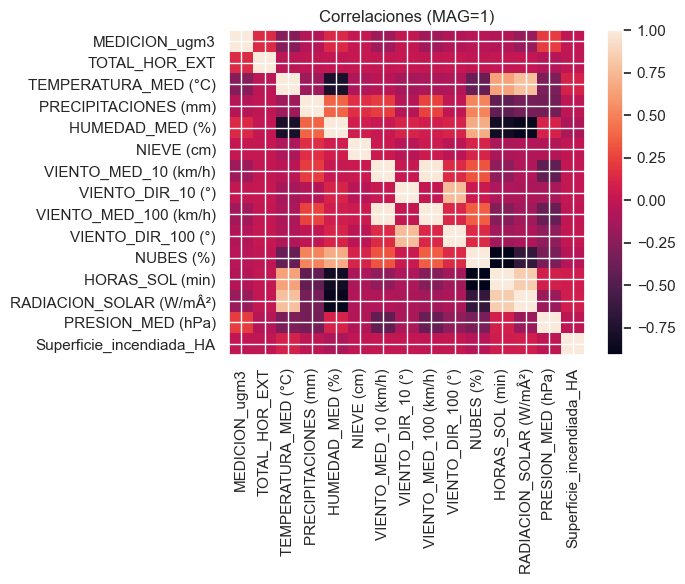

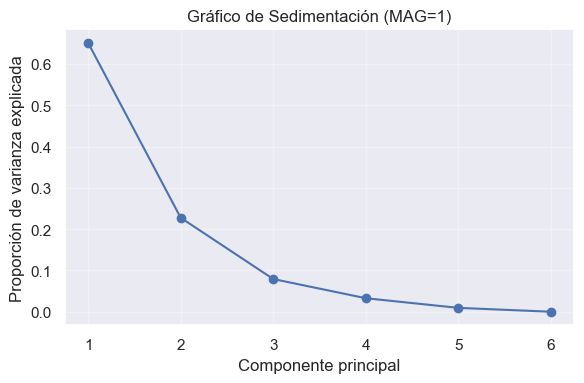

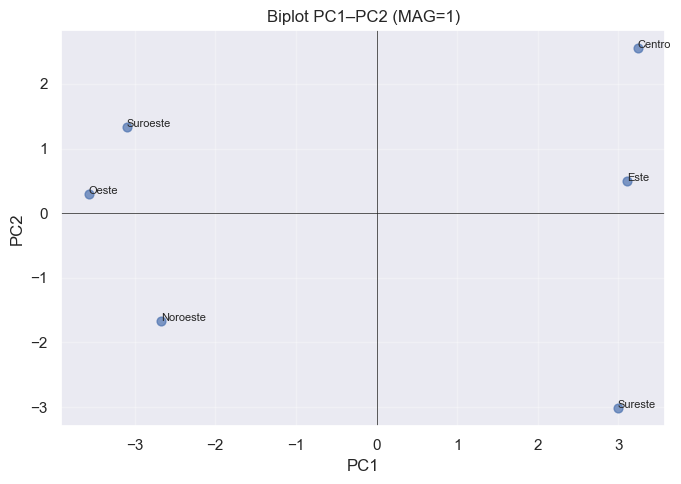


=== MAGNITUD = 10 ===


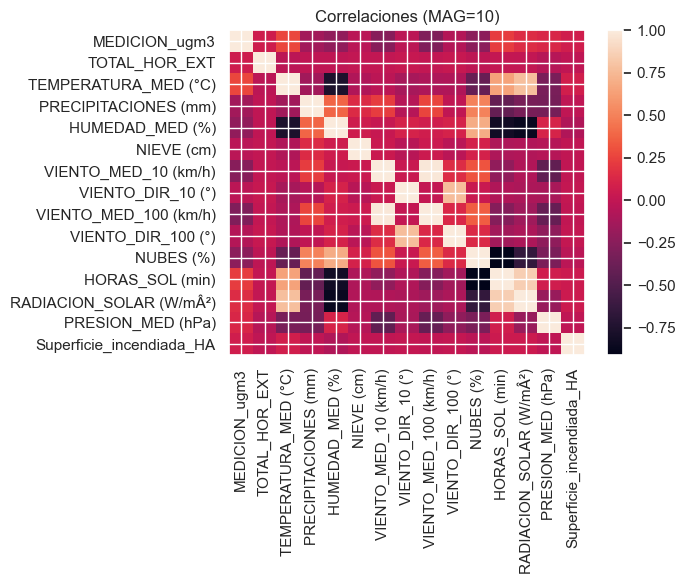

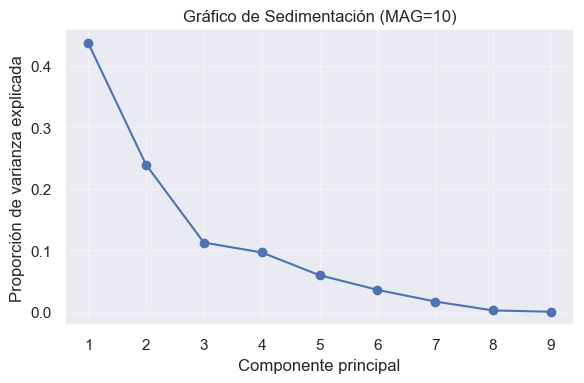

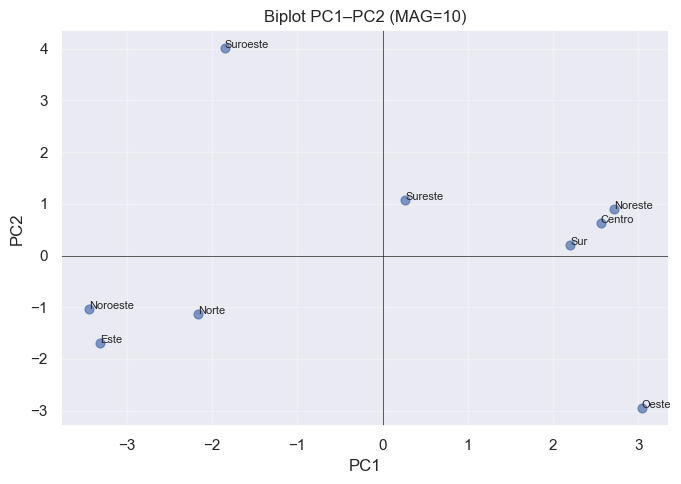


=== MAGNITUD = 12 ===


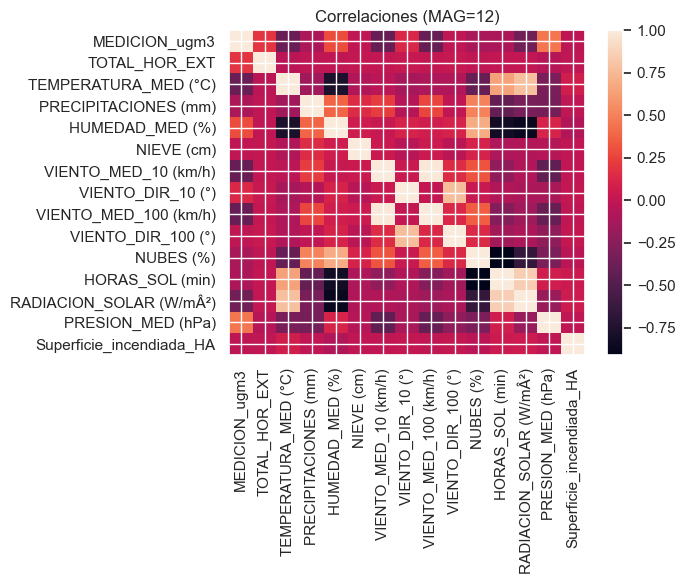

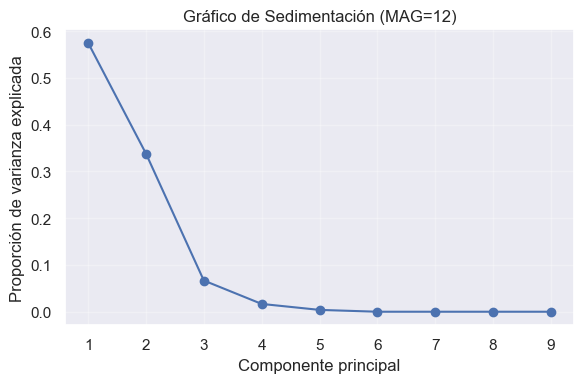

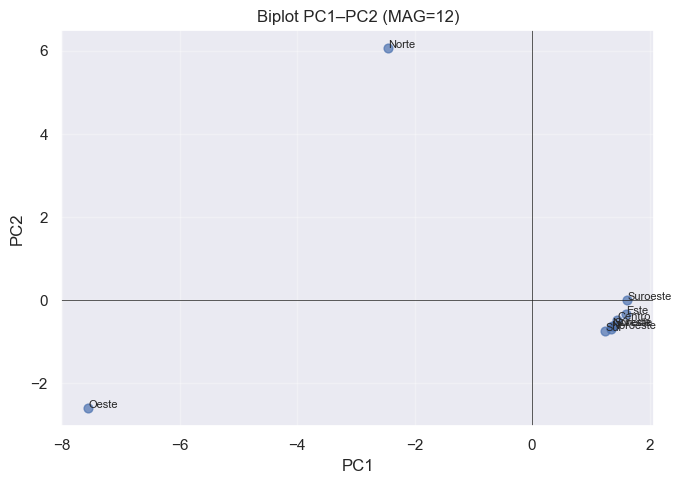


=== MAGNITUD = 14 ===


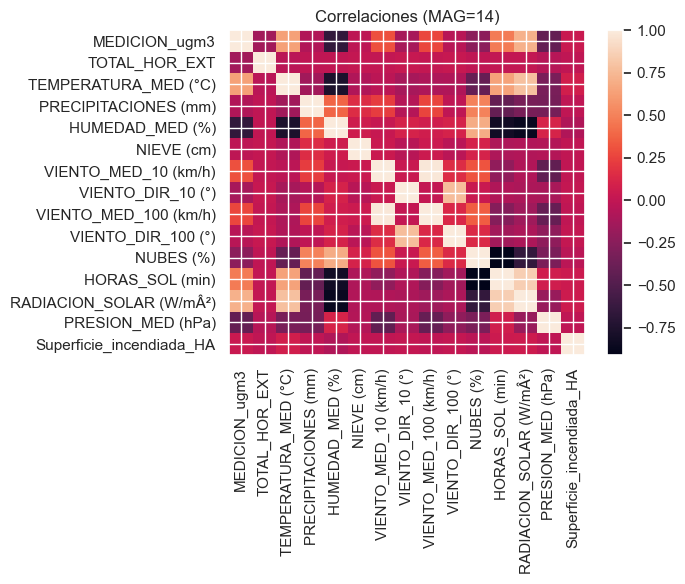

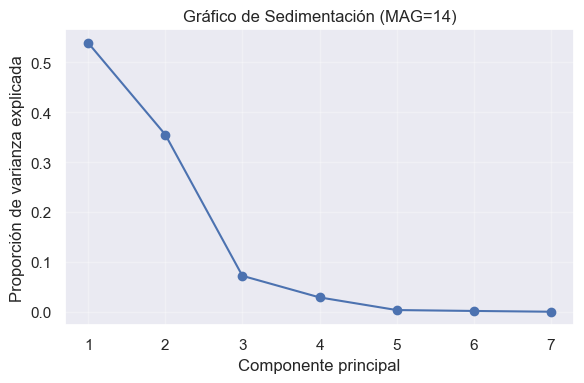

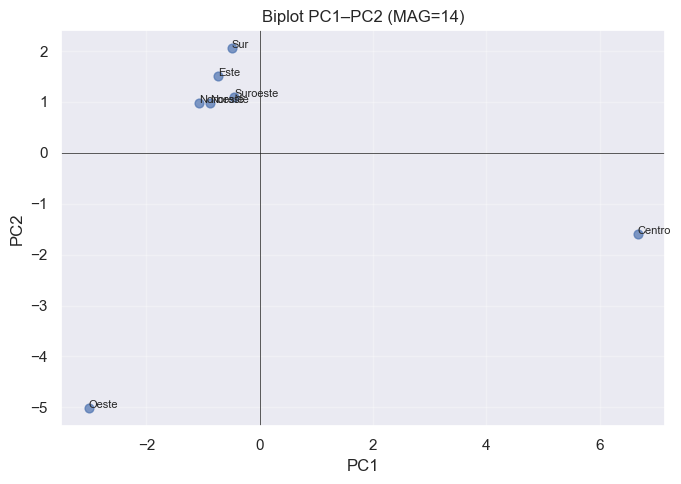


=== MAGNITUD = 20 ===


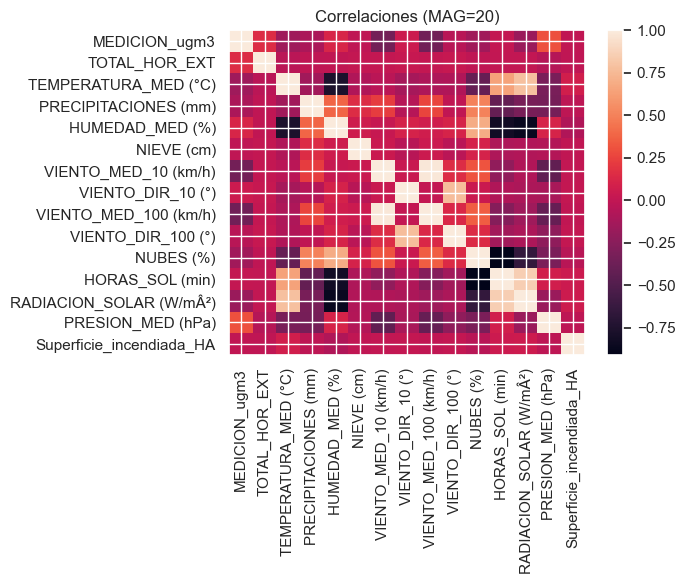

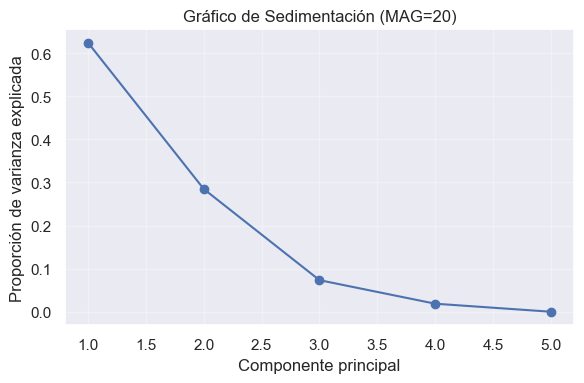

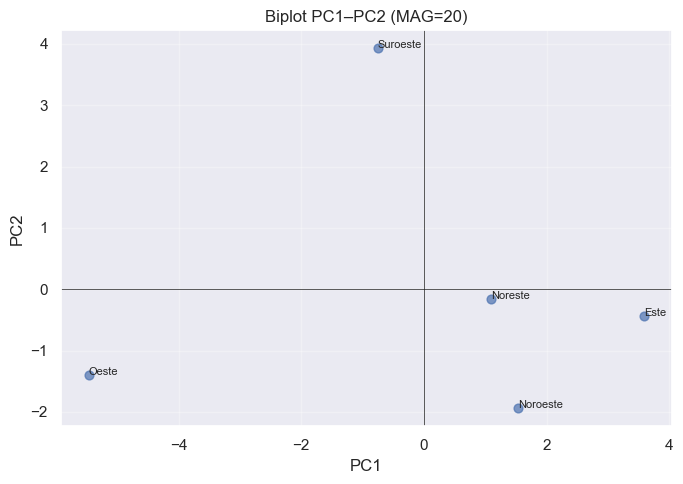


=== MAGNITUD = 30 ===


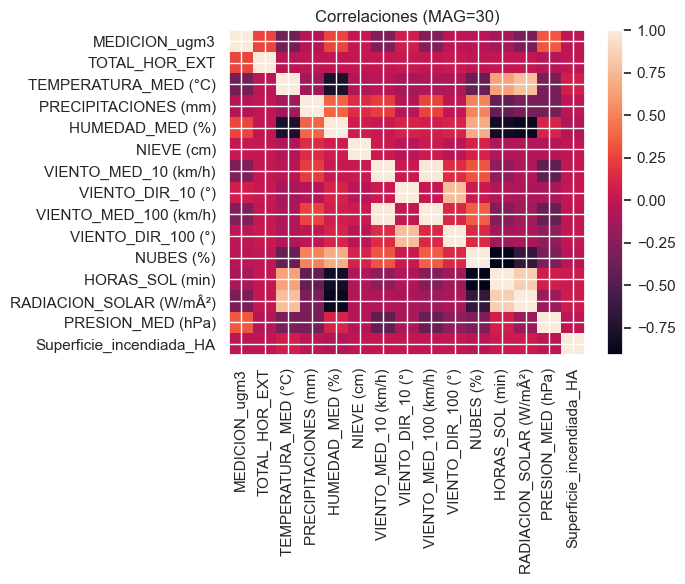

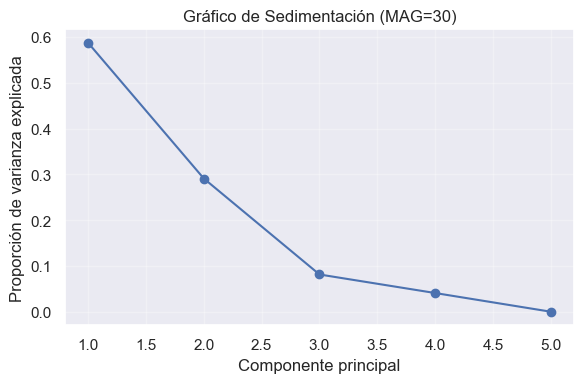

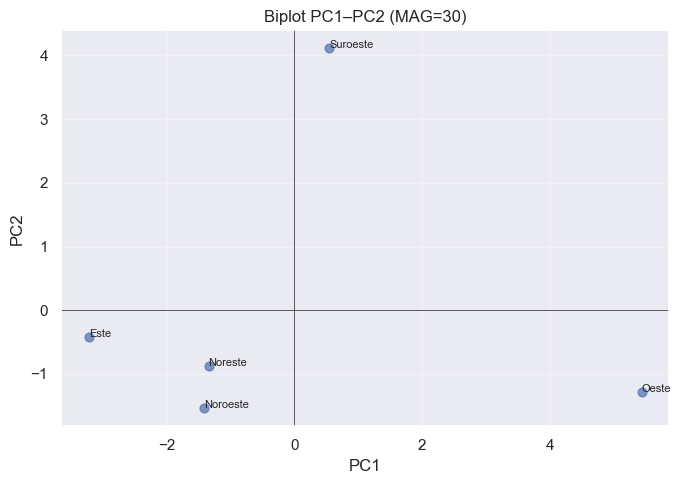


=== MAGNITUD = 35 ===


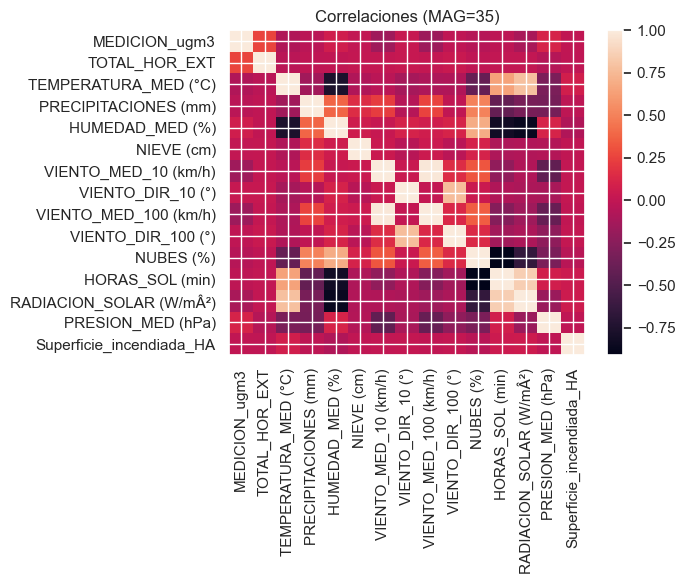

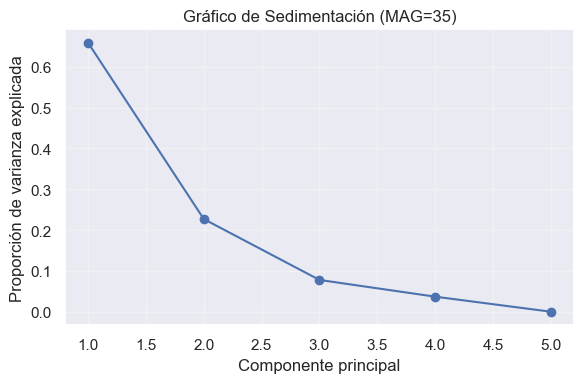

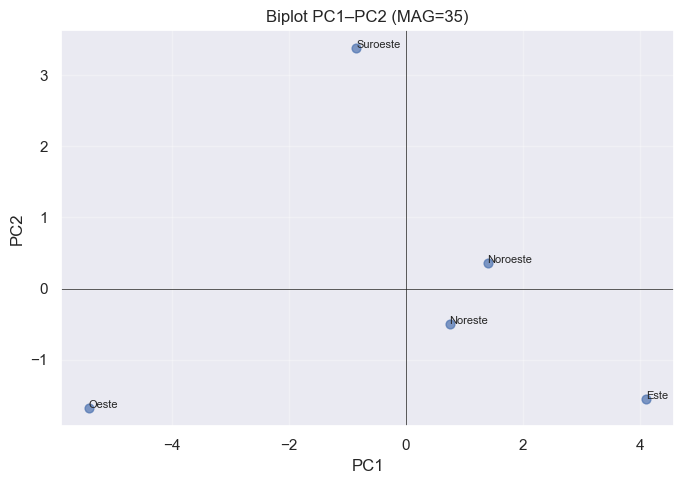


=== MAGNITUD = 6 ===


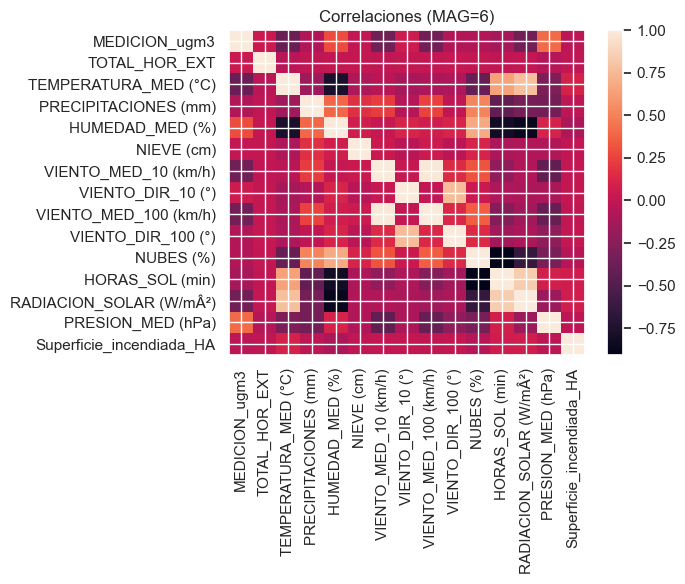

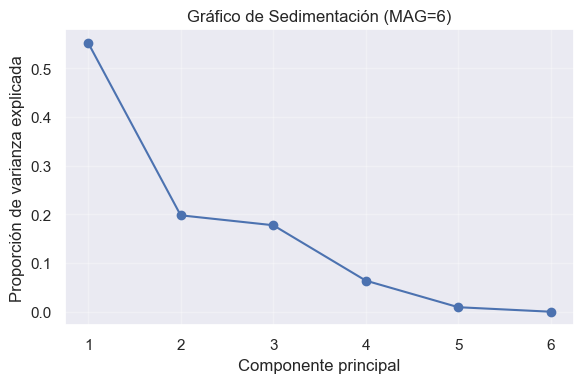

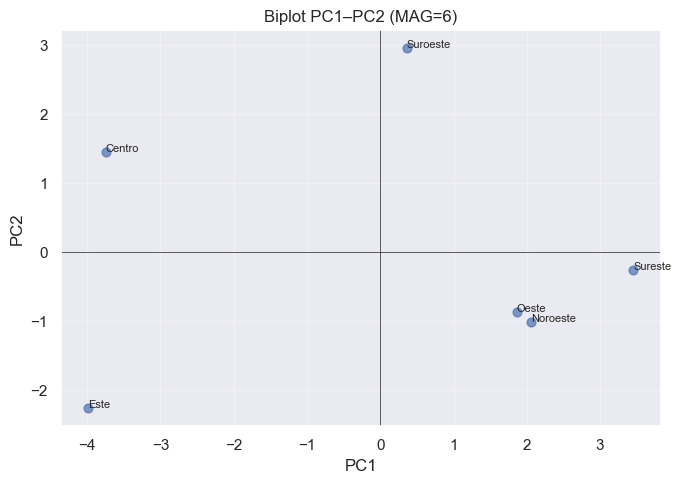


=== MAGNITUD = 7 ===


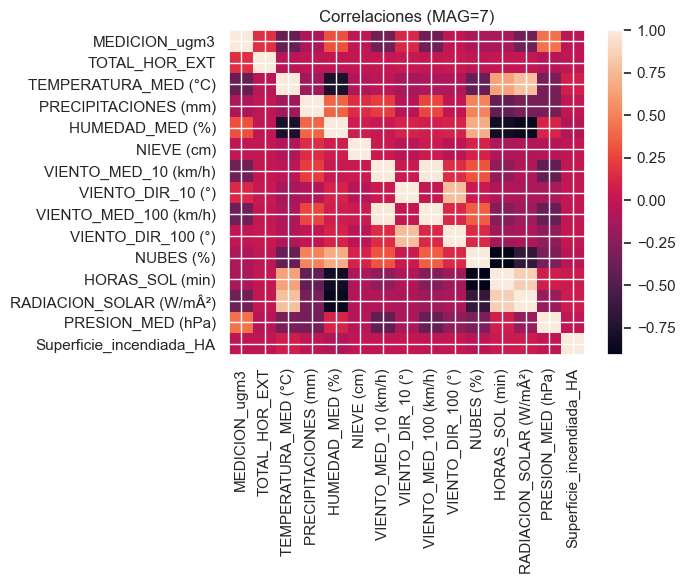

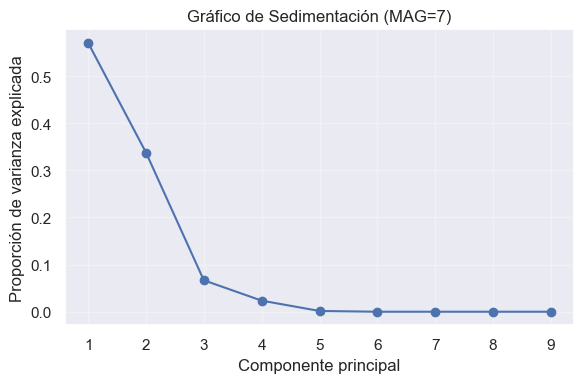

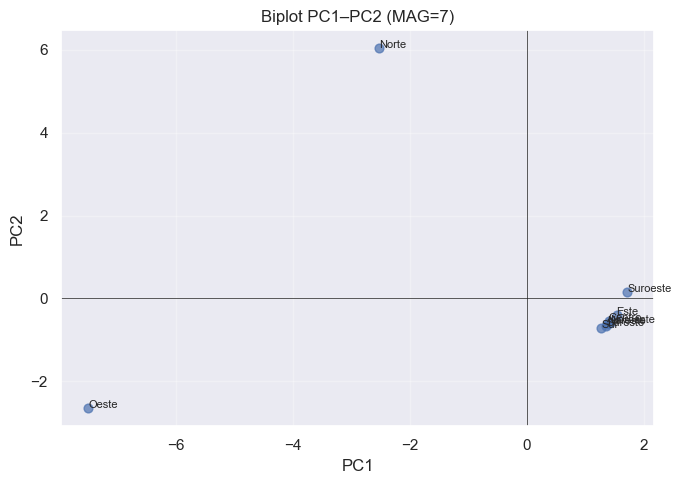


=== MAGNITUD = 8 ===


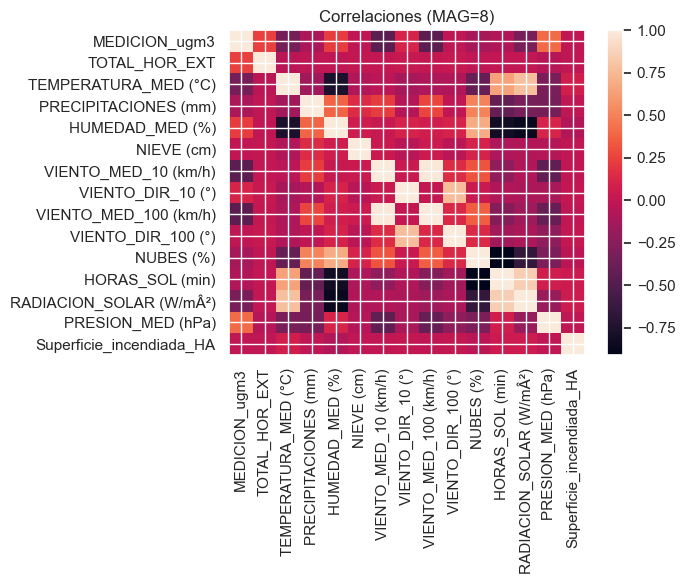

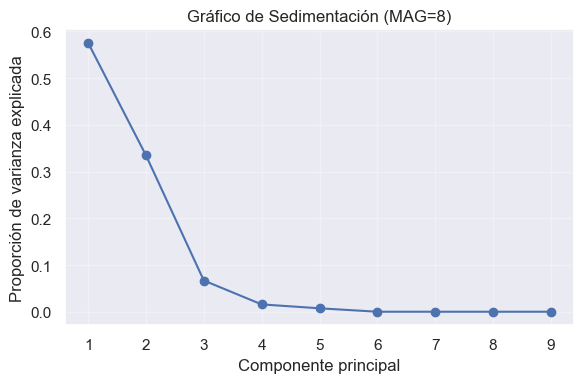

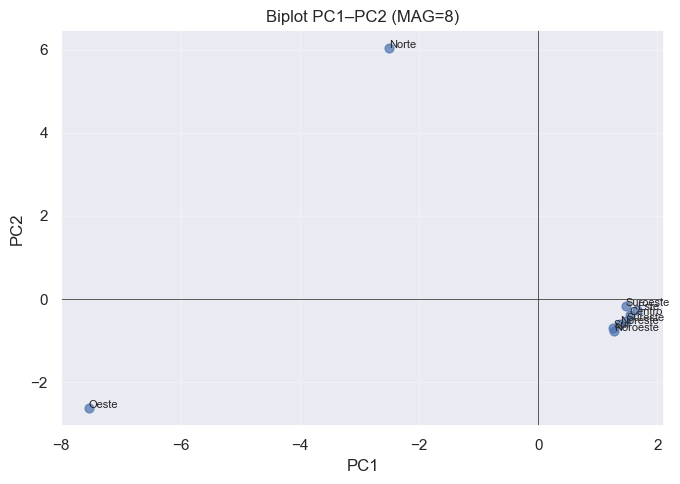


=== MAGNITUD = 9 ===


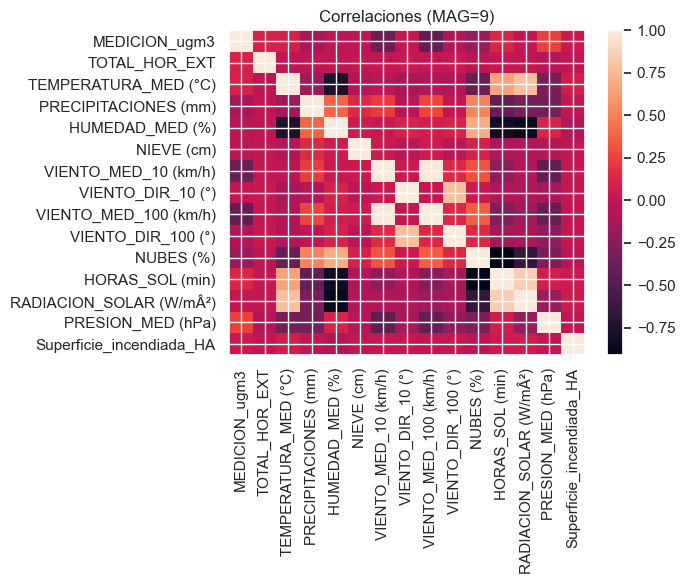

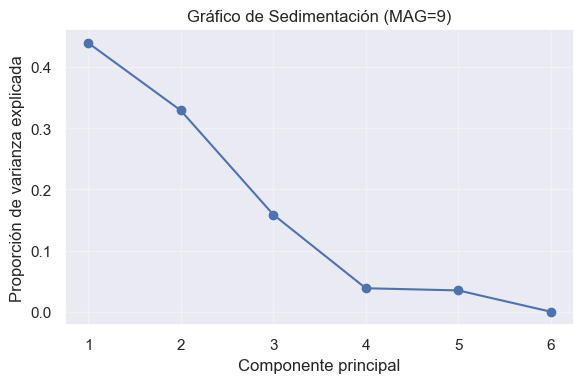

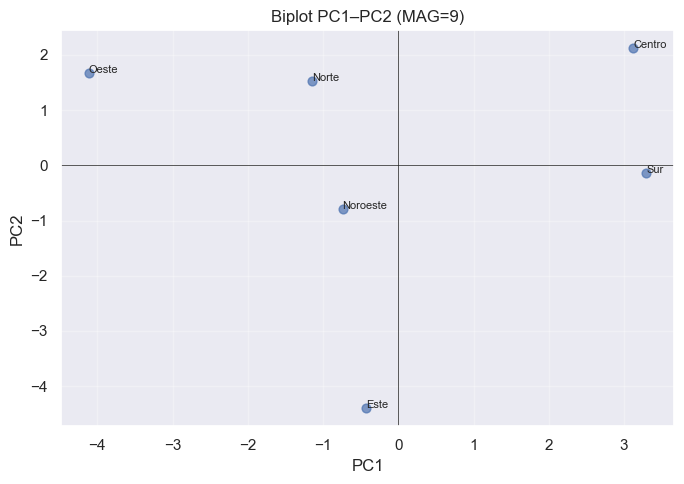

In [81]:
# 0) Identificación variables

ID_COL = "ZONA_ESTACION"
CAT_SPLIT_COL = "MAGNITUD"

# Umbrales de seguridad para ejecutar PCA
MIN_ZONES_FOR_PCA = 2
MIN_VARS_FOR_PCA = 2

# 1) Detectamos columnas numéricas candidatas
numeric_cols = df_completo_No_Supervisado.select_dtypes(include=["number"]).columns.tolist()

# 2) Bucle por niveles de MAGNITUD
niveles_magnitud = (
    df_completo_No_Supervisado[CAT_SPLIT_COL].cat.categories
    if pd.api.types.is_categorical_dtype(df_completo_No_Supervisado[CAT_SPLIT_COL])
    else sorted(df_completo_No_Supervisado[CAT_SPLIT_COL].unique())
)

resultados = {} # Se inicializa una lista donde iré guardando todos los resultados que vaya obteniendo.

for mag in niveles_magnitud:
    subset = df_completo_No_Supervisado[df_completo_No_Supervisado[CAT_SPLIT_COL] == mag].copy()
    if subset.empty:
        print(f"[MAG {mag}] Subconjunto vacío. Se omite.")
        continue

    print(f"\n=== MAGNITUD = {mag} ===") # Separador para mostrar a que magnitud se refieren los resultados que se van obteniendo.

    # 2.1) Correlaciones entre variables numéricas del subconjunto. Método de Pearson.
    corr = subset[numeric_cols].corr(method="pearson", min_periods=1) # min_periods=1: basta con que haya al menos 1 par válido de valores para calcular la correlación.
    
    # Se visualizan matrices de correlación:    
    plot_corr_heatmap(corr, title=f"Correlaciones (MAG={mag})")

    # 2.2) Agregación por ZONA_ESTACION: media, std, mediana y n_obs
    if ID_COL not in subset.columns:
        print(f"[MAG {mag}] No está {ID_COL} en columnas. Se omite.")
        resultados[mag] = {"corr": corr, "agg_stats": None, "pca": None}
        continue

    agg_stats = subset.groupby(ID_COL, observed=True).agg(
        **{f"{col}_mean":   (col, "mean")   for col in numeric_cols},
        **{f"{col}_std":    (col, "std")    for col in numeric_cols},
        **{f"{col}_median": (col, "median") for col in numeric_cols},
        n_obs=(ID_COL, "size"),
    ).reset_index()

    # Para PCA usaremos SOLO las medias por zona
    mean_cols = [c for c in agg_stats.columns if c.endswith("_mean")]
    zonas = agg_stats[ID_COL].astype(str).values

    # 2.3) Tipificación (estandarización)
    if len(mean_cols) < MIN_VARS_FOR_PCA or agg_stats.shape[0] < MIN_ZONES_FOR_PCA:
        print(f"[MAG {mag}] No hay suficientes variables/zonas para PCA (vars={len(mean_cols)}, zonas={agg_stats.shape[0]}).")
        resultados[mag] = {"corr": corr, "agg_stats": agg_stats, "pca": None}
        continue

    X = agg_stats[mean_cols].astype(float).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2.4) PCA (Hotelling)
    n_comp = min(agg_stats.shape[0], X_scaled.shape[1])  # seguro
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)
    explained = pca.explained_variance_ratio_

    # 2.5) Scree plot
    graf_sedimentacion (explained, title=f"Gráfico de Sedimentación (MAG={mag})")

    # 2.6) Biplot (PC1-PC2)
    if X_pca.shape[1] >= 2:
        feature_names = [c.replace("_mean", "") for c in mean_cols]
        plot_biplot(
            X_pca[:, :2],
            labels=zonas,
            title=f"Biplot PC1–PC2 (MAG={mag})"
        )
    else:
        print(f"[MAG {mag}] Solo hay 1 componente con varianza. Biplot 2D no aplicable.")

    # Guardar resultados por MAG
    resultados[mag] = {
        "corr": corr,
        "agg_stats": agg_stats,
        "pca": {
            "X_pca": X_pca,
            "explained_variance_ratio_": explained,
            "components_": pca.components_,
            "scaler_mean_": scaler.mean_,
            "scaler_scale_": scaler.scale_,
            "mean_feature_names": mean_cols,
            "zones": zonas,
        },
    }

A la vista de los resultados, donde Noreste y Noroeste tienen comportamientos muy parecidos, se decide unificar las zonas en SUR (Sureste, Sur, Suroeste); CENTRO (Este, Centro, Oeste) y NORTE (Noreste, Norte, Noroeste), de modo que:

## RENOMBRE DE NIVELES Y AGRUPACIÓN

Se renombran los niveles tal y como se indica anteriormente

In [82]:
map_zonas = {
    "Sureste": "SUR",
    "Sur": "SUR",
    "Suroeste": "SUR",
    "Este": "CENTRO",
    "Centro": "CENTRO",
    "Oeste": "CENTRO",
    "Noreste": "NORTE",
    "Norte": "NORTE",
    "Noroeste": "NORTE",
}

In [83]:
df_zonas_merged = df_completo_CA_TRAF_INC.copy()

In [84]:
df_zonas_merged["ZONA_ESTACION"] = (
    df_zonas_merged["ZONA_ESTACION"]
    .astype(object)                 # rompo temporalmente la categoría
    .replace(map_zonas)             # Renombro zonas
    .astype("category")             # vuelvo a declararlo como categórica
)

In [85]:
df_completo_CA_TRAF_INC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560340 entries, 0 to 560339
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               560340 non-null  datetime64[ns]
 1   ZONA_ESTACION             560340 non-null  category      
 2   MAGNITUD                  560340 non-null  category      
 3   MEDICION_ugm3             385174 non-null  float64       
 4   TEMPERATURA_MAX (°C)      560340 non-null  float64       
 5   TEMPERATURA_MIN (°C)      560340 non-null  float64       
 6   TEMPERATURA_MED (°C)      560340 non-null  float64       
 7   PRECIPITACIONES (mm)      560340 non-null  float64       
 8   HUMEDAD_MAX (%)           560340 non-null  float64       
 9   HUMEDAD_MIN (%)           560340 non-null  float64       
 10  HUMEDAD_MED (%)           560340 non-null  float64       
 11  NIEVE (cm)                560340 non-null  float64       
 12  VI

In [86]:
display(df_zonas_merged["ZONA_ESTACION"].cat.categories)

Index(['CENTRO', 'NORTE', 'SUR'], dtype='object')

Una vez se renmbran los niveles, se agrupan las instancias por: **ZONA_ESTACION**, **DIA/MES/ANO** y **MAGNITUD**

In [87]:
# Agrupar por ZONA_ESTACION, fecha y MAGNITUD con medias en numéricas
df_zonas_merged = (
    df_zonas_merged
    .groupby(["DIA/MES/ANO","MAGNITUD","ZONA_ESTACION"], observed=True)
    .mean(numeric_only=True)
    .reset_index()
)

In [88]:
df_zonas_merged.isna().sum()

DIA/MES/ANO                     0
MAGNITUD                        0
ZONA_ESTACION                   0
MEDICION_ugm3               16742
TEMPERATURA_MAX (°C)            0
TEMPERATURA_MIN (°C)            0
TEMPERATURA_MED (°C)            0
PRECIPITACIONES (mm)            0
HUMEDAD_MAX (%)                 0
HUMEDAD_MIN (%)                 0
HUMEDAD_MED (%)                 0
NIEVE (cm)                      0
VIENTO_MAX_10 (km/h)            0
VIENTO_MIN_10 (km/h)            0
VIENTO_MED_10 (km/h)            0
VIENTO_DIR_10 (°)               0
VIENTO_MAX_100 (km/h)           0
VIENTO_MIN_100 (km/h)           0
VIENTO_MED_100 (km/h)           0
VIENTO_DIR_100 (°)              0
NUBES (%)                       0
HORAS_SOL (min)                 0
RADIACION_SOLAR (W/mÂ²)         0
PRESION_MAX (hPa)               0
PRESION_MIN (hPa)               0
PRESION_MED (hPa)               0
TOTAL_HOR_EXT                   0
Superficie_incendiada_HA        0
dtype: int64

In [89]:
df_zonas_merged.shape

(186780, 28)

In [90]:
df_zonas_merged.head(20)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA
0,2010-01-01,1,CENTRO,8.666667,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2196158.0,0.0
1,2010-01-01,1,NORTE,10.000000,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,1489878.0,0.0
2,2010-01-01,1,SUR,6.250000,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2012742.333333,0.0
3,2010-01-01,10,CENTRO,9.500000,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2196158.0,0.0
4,2010-01-01,10,NORTE,11.000000,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,1489878.0,0.0
5,2010-01-01,10,SUR,10.000000,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2012742.333333,0.0
6,2010-01-01,12,CENTRO,29.166667,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2196158.0,0.0
7,2010-01-01,12,NORTE,32.166667,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,1489878.0,0.0
8,2010-01-01,12,SUR,34.000000,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2012742.333333,0.0
9,2010-01-01,14,CENTRO,61.833333,8.833577,4.033577,5.879828,0.1,81.77903,63.816715,...,28.416998,238.27025,55.933334,227.16466,1329.0,1017.5,1007.3,1011.06665,2196158.0,0.0


In [91]:
df_zonas_merged.tail(20)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA
186760,2025-06-30,20,NORTE,1.375000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,110268.0,6.358453
186761,2025-06-30,20,SUR,3.100000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,166164.0,6.358453
186762,2025-06-30,30,CENTRO,0.200000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,201208.666667,6.358453
186763,2025-06-30,30,NORTE,0.300000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,110268.0,6.358453
186764,2025-06-30,30,SUR,0.100000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,166164.0,6.358453
186765,2025-06-30,35,CENTRO,0.300000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,201208.666667,6.358453
186766,2025-06-30,35,NORTE,0.225000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,110268.0,6.358453
186767,2025-06-30,35,SUR,0.500000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,166164.0,6.358453
186768,2025-06-30,6,CENTRO,300.000000,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,201208.666667,6.358453
186769,2025-06-30,6,NORTE,NaN,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,...,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,110268.0,6.358453


In [92]:
df_zonas_merged.sample(20)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA
141151,2021-09-17,14,NORTE,48.500000,26.993578,13.693577,20.365660,0.000000,88.591300,32.581165,...,10.911670,220.477540,23.708334,552.75305,5459.0,1018.1,1012.5,1015.39996,127937.0,0.00
178953,2024-11-05,8,CENTRO,35.666667,19.063578,10.143578,13.921494,0.900000,92.368140,58.970486,...,5.240765,108.434944,38.550000,224.18259,2378.0,1024.8,1021.8,1023.39160,208528.666667,0.00
95476,2017-12-03,12,NORTE,64.222222,9.433578,-2.166423,2.578161,0.000000,81.828880,28.298540,...,17.603012,352.303960,4.420833,547.21440,2716.0,1032.7,1026.5,1029.53330,374545.666667,4.00
14950,2011-03-30,1,NORTE,3.000000,18.663578,9.233578,13.910244,0.000000,81.424680,45.486960,...,11.465107,289.844640,52.333332,227.18850,3967.0,1026.6,1021.2,1023.57495,1315376.0,0.00
125446,2020-05-29,20,NORTE,NaN,30.953577,14.243577,23.089410,0.000000,67.904200,21.045960,...,5.881714,96.581940,3.620833,852.63040,8183.0,1019.8,1010.8,1015.50020,75215.333333,1.40
121211,2020-01-22,1,SUR,8.000000,9.123577,4.523577,6.052327,4.100000,81.885300,67.226070,...,25.179878,51.076570,56.125000,249.03670,1194.0,1021.4,1016.9,1019.42505,206075.333333,0.00
36416,2013-01-08,30,SUR,0.600000,4.803577,-0.276423,2.183994,0.000000,98.508270,78.141220,...,4.389045,182.250640,45.416668,400.73532,2323.0,1034.4,1029.8,1031.45020,1445855.666667,0.00
15375,2011-04-11,9,CENTRO,7.666667,22.573578,9.923577,16.163996,0.000000,73.348595,33.866325,...,19.732603,26.584793,5.875000,732.52490,6523.0,1025.3,1020.8,1023.32500,1920830.333333,7.60
114084,2019-06-20,10,CENTRO,18.000000,27.723577,15.573577,22.787329,0.000000,61.529556,26.145160,...,12.151725,244.729800,20.745832,704.03590,7520.0,1013.8,1009.9,1012.27496,335104.0,4.00
49887,2014-02-20,7,CENTRO,45.166667,13.383577,0.173577,7.123993,0.000000,96.170906,62.406303,...,14.884599,221.847760,49.629166,226.75604,3483.0,1023.7,1018.0,1020.96674,1397286.333333,0.00


In [93]:
df_zonas_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             170038 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

# ANÁLISIS VALORES AUSENTES POR COMBINACIÓN ZONA y MAGNITUD

Ahora voy a tomar todas las combinaciones posibles de los niveles ZONA_ESTACION y MAGNITUD y analizar quien concentra mayor número de valores NA en la variable "MEDICION_ugm3".

In [94]:
# Todas las combinaciones posibles (respetando el orden si son categóricas)
zonas = (
    df_zonas_merged["ZONA_ESTACION"].cat.categories
    if isinstance(df_zonas_merged["ZONA_ESTACION"].dtype, CategoricalDtype)
    else pd.Index(df_zonas_merged["ZONA_ESTACION"].unique())
)

mags = (
    df_zonas_merged["MAGNITUD"].cat.categories
    if isinstance(df_zonas_merged["MAGNITUD"].dtype, CategoricalDtype)
    else pd.Index(df_zonas_merged["MAGNITUD"].unique())
)

combinaciones = pd.DataFrame(list(product(zonas, mags)), columns=["ZONA_ESTACION", "MAGNITUD"])

# Métricas de las combinaciones
agg_na = (
    df_zonas_merged
    .groupby(["ZONA_ESTACION","MAGNITUD"], observed=True)["MEDICION_ugm3"]
    .agg(NA_count=lambda s: s.isna().sum(), n_total="size")
    .reset_index()
)

# Merge con todas las combinaciones y completar ausentes
resultado = (
    combinaciones
    .merge(agg_na, on=["ZONA_ESTACION","MAGNITUD"], how="left")
    .fillna({"NA_count": 0, "n_total": 0})
)

# % de NAs (se evita división por 0)
resultado["pct_NA"] = np.where(
    resultado["n_total"] > 0,
    (resultado["NA_count"] / resultado["n_total"]*100).round(2),
    np.nan
)

# Se ordena de mayor a menor problema de NAs
resultado = resultado.sort_values(
    by=["pct_NA", "NA_count"], ascending=[False, False]
).reset_index(drop=True)

print(resultado.head(combinaciones.shape[0]))

   ZONA_ESTACION MAGNITUD  NA_count  n_total  pct_NA
0          NORTE        6      1975     5660   34.89
1          NORTE        1      1971     5660   34.82
2            SUR        6      1597     5660   28.22
3            SUR       35       577     5660   10.19
4            SUR       20       574     5660   10.14
5            SUR       30       567     5660   10.02
6            SUR        9       459     5660    8.11
7            SUR        1       416     5660    7.35
8          NORTE        9       386     5660    6.82
9         CENTRO       20       370     5660    6.54
10        CENTRO       30       367     5660    6.48
11        CENTRO       35       367     5660    6.48
12        CENTRO        1       347     5660    6.13
13         NORTE       10       341     5660    6.02
14         NORTE       20       340     5660    6.01
15         NORTE       30       340     5660    6.01
16         NORTE       35       340     5660    6.01
17        CENTRO       10       338     5660  

Se van a imputar NAs por los valores de las zonas conocidas, de modo que:

- Si hay 1 NA en un día (en una zona), en una magnitud concreta → reemplazar por la media de las otras dos.
- Si hay 2 NAs → ambos se igualan al valor conocido.
- Si hay 3 NAs → se dejan como están (NaN).


In [95]:
df = df_zonas_merged.copy()

In [96]:
# Asegurar tipos ya conocidos (rápido/no-op si ya lo están)
df["DIA/MES/ANO"] = pd.to_datetime(df["DIA/MES/ANO"], errors="coerce")

# Nos quedamos con las tres zonas objetivo (siempre en este orden)
zonas = ["SUR", "CENTRO", "NORTE"]
df = df[df["ZONA_ESTACION"].isin(zonas)]

# 1) Pivot ancho: índice = (fecha, magnitud); columnas = zonas; valores = MEDICION_ugm3
wide = (
    df.pivot_table(index=["DIA/MES/ANO", "MAGNITUD"],
                   columns="ZONA_ESTACION",
                   values="MEDICION_ugm3",
                   aggfunc="mean")
      .reindex(columns=zonas)  # asegurar orden columnas
)

# 2) Vectorización de la imputación
vals = wide.to_numpy(dtype=float)                      # matriz (n_filas × 3)
mask_nan = np.isnan(vals)                              # dónde hay NA
count_known = (~mask_nan).sum(axis=1)                  # k por fila
sum_known = np.nansum(vals, axis=1)                    # suma de conocidos por fila

# fill_val = sum/k solo cuando k=1 o k=2; si k=0 o k=3 -> NaN (no imputar)
fill_val = np.full(count_known.shape, np.nan, dtype=float)
valid_k = (count_known >= 1) & (count_known <= 2)
fill_val[valid_k] = sum_known[valid_k] / count_known[valid_k]

# Expandimos a matriz para poder reemplazar por fila
fill_mat = np.repeat(fill_val[:, None], vals.shape[1], axis=1)

# Dónde imputar: celdas NaN y filas con k=1 o k=2
to_impute = mask_nan & np.repeat(valid_k[:, None], vals.shape[1], axis=1)

# Guardamos indicador de imputación
imputed_flag = to_impute.copy()

# Reemplazo vectorizado
vals_imputed = np.where(to_impute, fill_mat, vals)

# 3) Volver a DataFrame ancho y a formato largo
wide_imputed = pd.DataFrame(vals_imputed, index=wide.index, columns=wide.columns)

long_imputed = (
    wide_imputed
      .reset_index()
      .melt(id_vars=["DIA/MES/ANO", "MAGNITUD"],
            value_vars=zonas,
            var_name="ZONA_ESTACION",
            value_name="MEDICION_ugm3_imput")
)

# Indicador de imputación en largo
imp_flag_long = (
    pd.DataFrame(imputed_flag, index=wide.index, columns=wide.columns)
      .reset_index()
      .melt(id_vars=["DIA/MES/ANO", "MAGNITUD"],
            value_vars=zonas,
            var_name="ZONA_ESTACION",
            value_name="IMPUTADO")
)

# 4) Fusionar con el original y sustituir solo donde estaba NaN
out = (
    df.merge(long_imputed, on=["DIA/MES/ANO","MAGNITUD","ZONA_ESTACION"], how="left")
      .merge(imp_flag_long, on=["DIA/MES/ANO","MAGNITUD","ZONA_ESTACION"], how="left")
)

mask_replace = out["MEDICION_ugm3"].isna() & out["MEDICION_ugm3_imput"].notna()
out.loc[mask_replace, "MEDICION_ugm3"] = out.loc[mask_replace, "MEDICION_ugm3_imput"]

# Si quieres conservar solo una columna final y el flag:
out = out.drop(columns=["MEDICION_ugm3_imput"])

# Métrica de control
antes = df["MEDICION_ugm3"].isna().sum()
desp  = out["MEDICION_ugm3"].isna().sum()
print(f"NAs antes: {antes} | NAs después: {desp}")

C:\Users\rosal\AppData\Local\Temp\ipykernel_61284\1666082770.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index=["DIA/MES/ANO", "MAGNITUD"],


NAs antes: 16742 | NAs después: 11154


In [97]:
df_zonas_merged = out.copy()

In [98]:
df_zonas_merged = df_zonas_merged.drop(columns=["IMPUTADO"])

In [99]:
# Todas las combinaciones posibles (respetando el orden si son categóricas)
zonas = (
    df_zonas_merged["ZONA_ESTACION"].cat.categories
    if isinstance(df_zonas_merged["ZONA_ESTACION"].dtype, CategoricalDtype)
    else pd.Index(df_zonas_merged["ZONA_ESTACION"].unique())
)

mags = (
    df_zonas_merged["MAGNITUD"].cat.categories
    if isinstance(df_zonas_merged["MAGNITUD"].dtype, CategoricalDtype)
    else pd.Index(df_zonas_merged["MAGNITUD"].unique())
)

combinaciones = pd.DataFrame(list(product(zonas, mags)), columns=["ZONA_ESTACION", "MAGNITUD"])

# Métricas de las combinaciones
agg_na = (
    df_zonas_merged
    .groupby(["ZONA_ESTACION","MAGNITUD"], observed=True)["MEDICION_ugm3"]
    .agg(NA_count=lambda s: s.isna().sum(), n_total="size")
    .reset_index()
)

# Merge con todas las combinaciones y completar ausentes
resultado = (
    combinaciones
    .merge(agg_na, on=["ZONA_ESTACION","MAGNITUD"], how="left")
    .fillna({"NA_count": 0, "n_total": 0})
)

# % de NAs (se evita división por 0)
resultado["pct_NA"] = np.where(
    resultado["n_total"] > 0,
    (resultado["NA_count"] / resultado["n_total"]*100).round(2),
    np.nan
)

# Se ordena de mayor a menor problema de NAs
resultado = resultado.sort_values(
    by=["pct_NA", "NA_count"], ascending=[False, False]
).reset_index(drop=True)

print(resultado.head(combinaciones.shape[0]))

   ZONA_ESTACION MAGNITUD  NA_count  n_total  pct_NA
0         CENTRO        1       338     5660    5.97
1         CENTRO       10       338     5660    5.97
2         CENTRO       12       338     5660    5.97
3         CENTRO       14       338     5660    5.97
4         CENTRO       20       338     5660    5.97
5         CENTRO       30       338     5660    5.97
6         CENTRO       35       338     5660    5.97
7         CENTRO        6       338     5660    5.97
8         CENTRO        7       338     5660    5.97
9         CENTRO        8       338     5660    5.97
10        CENTRO        9       338     5660    5.97
11         NORTE        1       338     5660    5.97
12         NORTE       10       338     5660    5.97
13         NORTE       12       338     5660    5.97
14         NORTE       14       338     5660    5.97
15         NORTE       20       338     5660    5.97
16         NORTE       30       338     5660    5.97
17         NORTE       35       338     5660  

# ANÁLISIS VALORES AUSENTES POR COMBINACIÓN AÑO y MES

Saco ahora la combinancion meses y años donde se concentran los valores NAs de la variable MEDICION_ugm3

In [100]:
# Copiamos el DataFrame original
df = df_zonas_merged.copy()

# Aseguramos que la columna de fecha esté en formato datetime
df["DIA/MES/ANO"] = pd.to_datetime(df["DIA/MES/ANO"], errors="coerce")

# Extraemos año y mes
df["ANYO"] = df["DIA/MES/ANO"].dt.year
df["MES"] = df["DIA/MES/ANO"].dt.month

# Agrupamos por año y mes y calculamos cantidad de NAs y total de registros
na_stats = (
    df.groupby(["ANYO", "MES"])["MEDICION_ugm3"]
      .agg(
          NA_count=lambda s: s.isna().sum(),
          n_total="size"
      )
      .reset_index()
)

# Calculamos el porcentaje de NAs
na_stats["pct_NA"] = (na_stats["NA_count"] / na_stats["n_total"]) * 100

# Filtramos solo las combinaciones con porcentaje de NAs mayor que 0
na_stats_filtrado = na_stats[na_stats["pct_NA"] > 0]

# Ordenamos de mayor a menor según porcentaje y cantidad de NAs
na_stats_filtrado = na_stats_filtrado.sort_values(["pct_NA", "ANYO", "MES", "NA_count"], ascending=[False, True, True, False]).reset_index(drop=True)

# Mostramos el resultado
print(na_stats_filtrado)


    ANYO  MES  NA_count  n_total      pct_NA
0   2020    3      1023     1023  100.000000
1   2020    4       990      990  100.000000
2   2020    5      1023     1023  100.000000
3   2020    6       990      990  100.000000
4   2020    7      1023     1023  100.000000
5   2020    8      1023     1023  100.000000
6   2020    9       990      990  100.000000
7   2020   10      1023     1023  100.000000
8   2020   11       990      990  100.000000
9   2020   12      1023     1023  100.000000
10  2024   12      1023     1023  100.000000
11  2025    4        33      990    3.333333


Dados estos resultados, ya sabemos donde se concentran los datos ausentes:

- Bloques enteros de meses con 100% de NAs (ej. marzo–diciembre 2020, diciembre 2024).
- Meses con valores ausentes pero de manera parcial (ej. abril 2025 con 3.3% de NAs).

# IMPUTACION - COMPARATIVA MODELOS

Para esta imputación dudo entre que modelos usar:
a) Modelo Prophet
b) Modelos Machine Learning (LightGBM/XGBoost)

Por tanto, llevaré a cabo el siguiente procedimiento:

1. Simulo huecos: escojo meses completos donde sí tienes datos (ej. todos los meses del añño 2019).
2. Imputo con Prophet y con LightGBM/XGBoost.
3. Comparo contra los datos reales para calcular las siguientes métricas:
   - MAE (error absoluto medio)
   - RMSE (raíz del error cuadrático medio)

El modelo con menor error consistente en varios meses simulados → es el que usas para los huecos reales.


In [101]:
target_col = "MEDICION_ugm3"
date_col   = "DIA/MES/ANO"
num_cols   = df_zonas_merged.select_dtypes(include=["number"]).columns.tolist()
EXOG_COLS  = [c for c in num_cols if c not in [target_col, date_col]]

Como se trata de un procesamiento muy pesado, vamos a tomar únicamente tres combinanciones diferentes de MAGNITUD y ZONA_ESTACION, para comprobar el modelo que mejor ajusta. Tomaremos 3 ejemplos:

- Ejemplo 1: MAGNITUD 35 y ZONA_ESTACION SUR
- Ejemplo 2: MAGNITUD 10 y ZONA_ESTACION CENTRO
- Ejemplo 3: MAGNITUD 9 y ZONA_ESTACION NORTE

El resultado arroja que el modelo que mejor ajusta los datos es el LGBM, por lo que usaré este modelo para estimar los datos faltantes de la variable "Medición_umg"

Pasamos pues a la imputacion de los valores faltantes

In [102]:
df_zonas_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  object        
 3   MEDICION_ugm3             175626 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

In [103]:
df_zonas_merged["ZONA_ESTACION"] = df_zonas_merged["ZONA_ESTACION"].astype("category")

In [104]:
df_zonas_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             175626 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

In [105]:
# 1) Ordeno por fecha y añade calendario
df_def = add_calendar_features(df_zonas_merged, date_col="DIA/MES/ANO")
df_def = df_def.sort_values("DIA/MES/ANO").reset_index(drop=True)

In [106]:
df_def.sample(20)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,Superficie_incendiada_HA,dow,month,dayofyear,dow_sin,dow_cos,m_sin,m_cos,doy_sin,doy_cos
85421,2017-02-01,30,CENTRO,0.800000,11.063578,3.973577,8.020244,0.0,93.879360,78.614540,...,0.000000,2,2,32,0.974928,-0.222521,8.660254e-01,5.000000e-01,0.523094,0.852275
183221,2025-03-15,6,SUR,300.000000,10.193577,-1.216423,4.745660,0.4,88.286970,42.073177,...,1.163302,5,3,74,-0.974928,-0.222521,1.000000e+00,6.123234e-17,0.955979,0.293434
47933,2013-12-23,20,SUR,2.700000,8.883577,1.263577,4.522744,0.0,91.675064,61.698032,...,0.000000,0,12,357,0.000000,1.000000,-2.449294e-16,1.000000e+00,-0.141444,0.989946
155979,2022-12-10,1,SUR,1.000000,12.283577,7.333577,9.316492,0.5,92.440254,60.913845,...,0.000000,5,12,344,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,-0.357464,0.933927
66019,2015-06-24,1,SUR,4.250000,29.693577,15.933578,22.856910,0.0,81.688670,27.761448,...,4.280000,2,6,175,0.974928,-0.222521,1.224647e-16,-1.000000e+00,0.130793,-0.991410
118189,2019-10-22,10,NORTE,9.000000,12.113577,7.133577,9.741077,2.8,89.464580,64.972360,...,0.000000,1,10,295,0.781831,0.623490,-8.660254e-01,5.000000e-01,-0.935075,0.354450
52878,2014-05-22,9,SUR,11.000000,17.093576,7.813577,12.141911,0.3,78.863310,41.489550,...,2.120000,3,5,142,0.433884,-0.900969,5.000000e-01,-8.660254e-01,0.643337,-0.765584
165118,2023-09-13,1,CENTRO,1.500000,27.333578,15.593577,21.256079,0.0,79.197370,36.140960,...,1.007132,2,9,256,0.974928,-0.222521,-1.000000e+00,-1.836970e-16,-0.952769,-0.303695
113909,2019-06-14,12,SUR,27.166667,24.543577,15.033577,19.853577,0.0,36.521442,18.838512,...,2.300000,4,6,165,-0.433884,-0.900969,1.224647e-16,-1.000000e+00,0.298569,-0.954388
94220,2017-10-26,6,SUR,500.000000,26.493578,8.623577,16.278160,0.0,75.432915,25.427198,...,3.300000,3,10,299,0.433884,-0.900969,-8.660254e-01,5.000000e-01,-0.908492,0.417903


In [107]:
df_def.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             175626 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

Haré imutación parciales de sub-datframes en función de cada uno de los niveles de la variable **MAGNITUD**. Por tanto:

In [108]:
# Niveles
niveles_mag = [m for m in df_def["MAGNITUD"].dropna().unique()]
# Si MAGNITUD es categórica, unique() puede devolver Categorical; lo forzamos a lista simple
niveles_mag = list(niveles_mag)

resultados = []          # para acumular sub-dataframes ya imputados
resumen_infos = []       # para guardar info de cada imputación

for mag in niveles_mag:
    sub = df_def[df_def["MAGNITUD"] == mag].copy()

    # Aseguramos que las exógenas existan en el sub (intersección, por si alguna falta)
    exog_cols_presentes = [c for c in (EXOG_COLS or []) if c in sub.columns]

    # Ejecutamos la imputación
    try:
        y_imputed, info = _fit_lgbm_and_impute(
            d_pair=sub,
            target_col=target_col,
            exog_cols=exog_cols_presentes,
            min_train=100,
            random_state=42
        )

        # Guardamos el resumen con el identificador de magnitud
        info_reg = {"MAGNITUD": mag, **(info if isinstance(info, dict) else {"info": info})}
        resumen_infos.append(info_reg)

        # Sustituimos NAs por imputaciones en el sub-dataframe
        if isinstance(info, dict) and info.get("ok") and (y_imputed is not None) and (len(y_imputed) > 0):
            sub.loc[y_imputed.index, target_col] = y_imputed

        # Acumulamos el sub ya procesado
        resultados.append(sub)

        print(f"[OK] MAGNITUD={mag}: imputación realizada. Filas: {len(sub)}")

    except Exception as e:
        # Si algo falla, añadimos el sub sin cambios pero registramos el error
        resumen_infos.append({"MAGNITUD": mag, "ok": False, "error": str(e)})
        resultados.append(sub)
        print(f"[ERROR] MAGNITUD={mag}: {e}")

# Recombinamos todos los sub-dataframes
df_imputado = (
    pd.concat(resultados, axis=0)
      .sort_index()   # mantenemos el orden original si el índice era único/temporal
)

resumen_df = pd.DataFrame(resumen_infos)

print("\n=== Resumen de imputaciones por MAGNITUD ===")
print(resumen_df)

# Si quieres que el resultado final reemplace a df_def:
df_def = df_imputado

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 5948
[LightGBM] [Info] Number of data points in the train set: 15966, number of used features: 30
[LightGBM] [Info] Start training from score 5.476573
[OK] MAGNITUD=1: imputación realizada. Filas: 16980
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 5948
[LightGBM] [Info] Number of data points in the train set: 15966, number of used features: 30
[LightGBM] [Info] Start training from score 10.437148
[OK] MAGNITUD=9: imputación realizada. Filas: 16980
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 5948
[LightGBM] [Info] Number of data points in the train set: 15966, number of used features: 30
[LightGBM] [Info] Start training from score 34.522156
[OK] MAGNITUD=8: imputación realizada. Filas: 16980
[LightGBM] [Warning] Found whitespace in feature_names, replac

Elimino las variables dayofyear, dow_sin, dow_cos, m_sin, m_cos, doy_sin y doy_cos ya que considero que no aportan información valiosa al estudio o puede generan fuerte correlacion con el resto de variables

In [109]:
df_def = df_def.drop(columns=["dayofyear", "dow_sin", "dow_cos", "m_sin", "m_cos", "doy_sin", "doy_cos"])

Finalmente, declaro las variables dow, month como categóricas.

In [110]:
cols_cat = ["dow", "month"]
df_def[cols_cat] = df_def[cols_cat].astype("category")

# COMPROBACIÓN

In [111]:
df_def.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186780 entries, 0 to 186779
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             186780 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VIENTO_

Compruebo el número de valores ausentes en cada una de las variables

In [112]:
df_def.isna().sum()

DIA/MES/ANO                 0
MAGNITUD                    0
ZONA_ESTACION               0
MEDICION_ugm3               0
TEMPERATURA_MAX (°C)        0
TEMPERATURA_MIN (°C)        0
TEMPERATURA_MED (°C)        0
PRECIPITACIONES (mm)        0
HUMEDAD_MAX (%)             0
HUMEDAD_MIN (%)             0
HUMEDAD_MED (%)             0
NIEVE (cm)                  0
VIENTO_MAX_10 (km/h)        0
VIENTO_MIN_10 (km/h)        0
VIENTO_MED_10 (km/h)        0
VIENTO_DIR_10 (°)           0
VIENTO_MAX_100 (km/h)       0
VIENTO_MIN_100 (km/h)       0
VIENTO_MED_100 (km/h)       0
VIENTO_DIR_100 (°)          0
NUBES (%)                   0
HORAS_SOL (min)             0
RADIACION_SOLAR (W/mÂ²)     0
PRESION_MAX (hPa)           0
PRESION_MIN (hPa)           0
PRESION_MED (hPa)           0
TOTAL_HOR_EXT               0
Superficie_incendiada_HA    0
dow                         0
month                       0
dtype: int64

In [113]:
df_def.describe(include="all")

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA,dow,month
count,186780,186780,186780,186780.000000,186780.000000,186780.000000,186780.000000,186780.000000,186780.000000,186780.000000,...,186780.000000,186780.000000,186780.000000,186780.000000,186780.000000,186780.000000,186780.0,186780.000000,186780.0,186780.0
unique,NaN,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,7.0,12.0
top,NaN,1,CENTRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,0.0,1.0
freq,NaN,16980,62260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,26697.0,16368.0
mean,2017-09-30 12:00:00,NaN,NaN,49.809813,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,...,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497,714785.612662,15.794902,NaN,NaN
min,2010-01-01 00:00:00,NaN,NaN,-0.359742,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,...,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300,828.333333,0.000000,NaN,NaN
25%,2013-11-15 18:00:00,NaN,NaN,2.000000,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,...,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465,176897.416667,0.000000,NaN,NaN
50%,2017-09-30 12:00:00,NaN,NaN,11.250000,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,...,21.972920,547.991000,4788.000000,1019.400000,1014.100000,1016.787470,534144.166667,0.000000,NaN,NaN
75%,2021-08-15 06:00:00,NaN,NaN,38.833333,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,...,45.892708,707.436837,6986.250000,1024.200000,1019.000000,1021.401030,1191272.583333,2.700000,NaN,NaN
max,2025-06-30 00:00:00,NaN,NaN,1500.000000,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,...,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200,2214756.666667,21272.670000,NaN,NaN


In [114]:
fecha_min = df_def["DIA/MES/ANO"].min()
fecha_max = df_def["DIA/MES/ANO"].max()

print(f"Se comprueba que no existen valores ausentes en ninguna variable en todo el rango de fecha: {fecha_min.date()} → {fecha_max.date()}")

Se comprueba que no existen valores ausentes en ninguna variable en todo el rango de fecha: 2010-01-01 → 2025-06-30


In [115]:
df_def.sample(50)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA,dow,month
161682,2023-06-01,30,NORTE,0.225000,21.713577,13.463577,17.242743,6.099999,87.885290,50.837353,...,33.891666,621.954200,6016.0,1015.1,1010.2,1012.97490,126443.666667,0.000000,3,6
95958,2017-12-17,14,NORTE,37.000000,10.073577,-1.526423,3.283994,0.000000,86.810880,41.661182,...,11.962501,461.651000,2344.0,1034.1,1029.0,1031.17920,364926.333333,0.000000,6,12
92307,2017-08-29,7,CENTRO,5.333333,24.823578,15.603578,19.571080,1.300000,94.898290,45.422394,...,23.954168,561.318850,5721.0,1015.6,1011.6,1014.12910,647260.0,0.000000,1,8
163682,2023-08-01,35,SUR,0.100000,35.683580,19.613577,28.123160,0.000000,49.044655,19.422830,...,0.000000,861.300050,8002.0,1015.9,1010.7,1013.37506,145841.666667,7.467898,1,8
157753,2023-02-02,9,NORTE,11.000000,14.363577,-0.606423,5.650661,0.000000,82.837360,25.671001,...,0.375000,613.266660,3532.0,1032.3,1028.7,1030.47910,130468.333333,0.000000,3,2
108892,2019-01-13,10,SUR,23.333333,12.073577,-2.956423,2.621910,0.000000,91.375010,44.508057,...,6.166667,544.237500,2620.0,1031.7,1026.0,1028.80820,300897.333333,1.000000,6,1
30165,2012-07-03,6,CENTRO,266.666667,32.403576,15.293577,25.801489,0.000000,39.990910,15.582601,...,20.175001,735.111270,7790.0,1017.2,1010.8,1014.13330,1715535.333333,10.940000,1,7
135787,2021-04-07,30,CENTRO,0.350000,20.083578,5.313577,12.538577,0.000000,71.803474,23.609375,...,22.162500,637.880000,6780.0,1021.8,1013.8,1017.09174,195295.333333,0.000000,2,4
109064,2019-01-18,12,SUR,154.666667,7.713577,-3.456423,1.650244,0.200000,90.473800,58.322353,...,36.808334,205.594450,2208.0,1023.6,1018.2,1020.64160,357696.333333,0.000000,4,1
42529,2013-07-12,10,NORTE,37.333333,35.323578,21.293577,28.190240,0.000000,53.657883,13.025014,...,0.891667,886.840940,8312.0,1014.4,1010.4,1012.48340,1015604.333333,16.740000,4,7


In [116]:
df_def[df_def["DIA/MES/ANO"].dt.year == 2020].sample(20)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA,dow,month
127201,2020-07-21,1,NORTE,4.862063,34.023580,21.013577,27.415665,2.3,62.587566,24.153996,...,20.050001,651.080200,6392.0,1017.4,1013.8,1015.65010,99055.0,0.000,1,7
131001,2020-11-13,12,CENTRO,78.693060,15.193577,6.273577,10.313160,0.0,90.067276,62.226864,...,36.575000,346.344820,2630.0,1023.1,1019.9,1021.44580,209003.0,0.000,4,11
131139,2020-11-17,20,CENTRO,4.446741,16.433577,6.343577,10.451078,0.0,95.645040,66.071480,...,20.750000,500.450470,2647.0,1029.3,1026.0,1027.23330,192784.333333,0.000,1,11
126572,2020-07-02,30,CENTRO,0.221244,32.883575,17.463577,26.189827,0.0,54.114952,19.718767,...,7.333333,838.261600,8304.0,1016.2,1012.0,1013.69170,193798.0,3.740,3,7
123676,2020-04-05,1,CENTRO,4.448738,18.963577,8.503577,14.014829,0.0,83.432360,42.286987,...,57.083332,337.160950,5358.0,1018.8,1014.3,1016.65840,20081.0,0.000,6,4
123197,2020-03-22,7,SUR,1.458433,12.433578,6.153577,8.804410,1.8,89.525840,57.658690,...,68.291664,273.211300,2579.0,1014.7,1010.3,1012.44995,22724.333333,0.000,6,3
130127,2020-10-18,7,SUR,12.987105,20.603577,4.513578,11.970661,0.0,76.197220,28.860014,...,22.574999,497.617000,4123.0,1022.6,1018.7,1020.38324,91975.666667,16.590,6,10
127536,2020-07-31,12,CENTRO,39.971269,38.123577,19.913578,29.838575,0.0,60.368305,12.956251,...,1.625000,841.194030,7996.0,1015.6,1012.5,1014.03340,168006.666667,19.500,4,7
123725,2020-04-07,8,CENTRO,26.455597,18.333578,11.423577,14.427742,9.2,93.194500,62.428024,...,56.833332,368.659940,4375.0,1024.1,1021.5,1022.92920,42220.333333,0.000,1,4
126100,2020-06-18,8,CENTRO,19.998171,29.553577,13.213577,22.198160,0.0,60.117710,19.589130,...,22.166666,639.391600,7938.0,1014.7,1010.2,1012.69586,167853.333333,14.000,3,6


In [117]:
df_def[(df_def["DIA/MES/ANO"].dt.year == 2020) & (df_def["MAGNITUD"] == "20")].sample(20)

,DIA/MES/ANO,MAGNITUD,ZONA_ESTACION,MEDICION_ugm3,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),...,NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),TOTAL_HOR_EXT,Superficie_incendiada_HA,dow,month
125747,2020-06-07,20,SUR,0.636620,23.943577,14.133577,18.890661,6.5,72.828255,34.791134,...,44.291668,469.30350,5525.0,1013.3,1006.4,1008.81670,74384.333333,0.00,6,6
130017,2020-10-14,20,CENTRO,1.508526,17.403578,7.333577,12.644829,0.0,65.595894,30.343422,...,18.666666,461.49152,3849.0,1017.3,1011.9,1013.50420,189183.0,0.00,2,10
124474,2020-04-29,20,SUR,0.506557,19.083578,5.683577,12.880661,0.0,88.070816,40.146202,...,43.454166,435.24396,6290.0,1019.6,1016.2,1017.82916,60786.333333,0.00,2,4
120580,2020-01-02,20,SUR,6.400000,10.723577,0.743577,4.283161,0.0,86.438690,55.720420,...,8.491668,537.04260,2586.0,1033.8,1030.3,1031.81240,201399.0,0.00,3,1
125068,2020-05-17,20,NORTE,0.553929,23.753578,9.353578,16.749826,0.0,74.051340,26.219942,...,19.083334,647.92150,7195.0,1023.0,1019.3,1021.52496,13657.333333,0.00,6,5
125153,2020-05-20,20,SUR,2.008849,31.223577,11.233578,21.960243,0.0,83.156520,12.036403,...,0.275000,877.81055,8409.0,1018.0,1013.8,1016.35840,85895.666667,0.00,2,5
125582,2020-06-02,20,SUR,1.859653,30.073578,15.743577,22.972746,0.0,70.897440,22.207127,...,21.187498,717.80610,7786.0,1015.4,1010.7,1013.27905,116236.0,2.86,1,6
127595,2020-08-02,20,SUR,0.437310,35.333576,20.083578,27.633577,0.0,60.118755,21.078450,...,12.325001,739.30660,7662.0,1016.4,1010.7,1014.13740,88778.666667,1074.36,6,8
122183,2020-02-20,20,SUR,5.600000,17.533577,1.153577,8.640243,0.0,76.982956,31.048862,...,0.037500,655.71670,4385.0,1027.5,1022.9,1025.23740,202169.0,0.00,3,2
122461,2020-02-28,20,NORTE,1.725000,18.313578,2.573577,10.322743,0.0,84.804570,29.497332,...,19.975000,483.13632,4547.0,1024.5,1014.9,1020.39580,143436.0,8.23,4,2


In [118]:
df_def.to_parquet("05_DATASET_FINAL.parquet", index=False)